## 타이타닉 데이터를 활용한 탑승자의 생사여부 예측


In [1]:
## Settings
options(warn = -1) ## 경고 지우기
options(repr.plot.width=8, repr.plot.height=6) # 플랏 크기 조절
Sys.setlocale(category = "LC_ALL", locale = "ko_KR.UTF-8") # 한글 설정

## Libraries
library(stringr) # stringr 불러오기
library(dplyr) # dplyr 불러오기
library(plotrix) # 3D pie
library(RColorBrewer) # color package
library(tidyverse)
library(hrbrthemes)
library(kableExtra)
library(caret)
library(randomForest)
library(nnet)

#library(extrafont)

[1] "ko_KR.UTF-8/ko_KR.UTF-8/ko_KR.UTF-8/C/ko_KR.UTF-8/C"


다음의 패키지를 부착합니다: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

다음의 패키지를 부착합니다: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


필요한 패키지를 로딩중입니다: lattice


다음의 패키지를 부착합니다: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


다음의 패키지를 부착합니다: ‘ran

In [2]:
train_df <- read.csv("../Data/Titanic_train.csv")

In [3]:
head(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


In [4]:
tail(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
886,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39,0,5,382652,29.125,,Q
887,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.000,,S
888,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.000,B42,S
889,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NA,1,2,W./C. 6607,23.450,,S
890,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.000,C148,C
891,891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.750,,Q


In [5]:
str(train_df)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


### 컬럼 내용 확인
- survived : 생존여부 (0:dead , 1: live)
- Pclass : 티켓 등급 1:1st, 2: 2nd, 3:3rd -> 숫자에 의미가 있으므로 원핫 인코딩 하면 안됨
- Sibsp : 함께 탑승한 형제, 자매, 배우자의 수
- Parch : 함께 탑승한 부모, 자식의 수
- Fare : 운임 ( 나말고 더불어 타는 것들, 자동차, 쌀 등등 운임많으면 부자)
- Cabin : 객실 번호 
- Embarked : 탑승항구 , S = Southampton , C = Chersbourg(유럽 부자), Q = Queenstown 

In [6]:
# 결측치 체크
checkData <- function(data){
		options(repr.plot.width=8, repr.plot.height=6) # 플랏 크기 조절
    par(family ="AppleGothic",bg='grey') # 그래프 배경및 한글설정
    
    cat("*****************(1.DATA HEAD)*****************\n\n");
        print(head(data,2))
    cat("******************************************************************\n\n");
    cat("*****************(2.DATA TAIL)*****************\n\n");
        print(tail(data,2))
    cat("******************************************************************\n\n");
    cat("*****************(3.DATA Structure)*****************\n\n");
        str(data)
    cat("******************************************************************\n\n");
    # data 의 기본 통계량 보기
    cat("*****************(4.DATA Summary)*****************\n\n");
        print(summary(data))
    cat("******************************************************************\n\n");
    cat("*****************(5.NA check)*****************\n\n");
        cat(" 5.1 Data 전체에서의 NA 개수:", sum(is.na(data)),"\n\n")
        # 컬럼 별 na 확인
        cat(" 5.2 Column 별 NA check \n")
        for(i in 1:ncol(data)){
            cat("  col[",colnames(data[i]), "] --> NA 개수:",(sum(is.na(data[,i]))),"\n")
        }
        ## 컬럼별 na 합계 계산. 
        cat("column 별 na 합계 \n",colSums(is.na(data)) ,"\n")
    cat("******************************************************************\n\n");
    cat("*****************(6.Colum 별 data 빈도수 형평성 검사)*****************\n\n");
    #A 컬럼의 최대값 최소값 빈도수
    for(i in 1:ncol(data)){
        #cat("-----",colnames(data)[i] ," 컬럼의 빈도 분석결과----- \n")
        cat("최빈값:",max(table(data[,i])), "최소빈도값 :", min(table(data[,i])), "\n")
        barplot(table(data[,i]),

            main = paste(colnames(data)[i] ," 컬럼의 데이터 별 빈도 분석 \n"),
            ylab = "빈도수",
            xlab = "데이터값",
        )
        
        cat("\n")
        # 각 컬럼의 빈도수의 최대값, 최소값 구하기 
        cat(colnames(data)[i],"컬럼의 빈도수의 최대값과 최소값\n")
    }
}


*****************(1.DATA HEAD)*****************

  PassengerId Survived Pclass
1           1        0      3
2           2        1      1
                                                 Name    Sex Age SibSp Parch
1                             Braund, Mr. Owen Harris   male  22     1     0
2 Cumings, Mrs. John Bradley (Florence Briggs Thayer) female  38     1     0
     Ticket    Fare Cabin Embarked
1 A/5 21171  7.2500              S
2  PC 17599 71.2833   C85        C
******************************************************************

*****************(2.DATA TAIL)*****************

    PassengerId Survived Pclass                  Name  Sex Age SibSp Parch
890         890        1      1 Behr, Mr. Karl Howell male  26     0     0
891         891        0      3   Dooley, Mr. Patrick male  32     0     0
    Ticket  Fare Cabin Embarked
890 111369 30.00  C148        C
891 370376  7.75              Q
******************************************************************

*****************(3

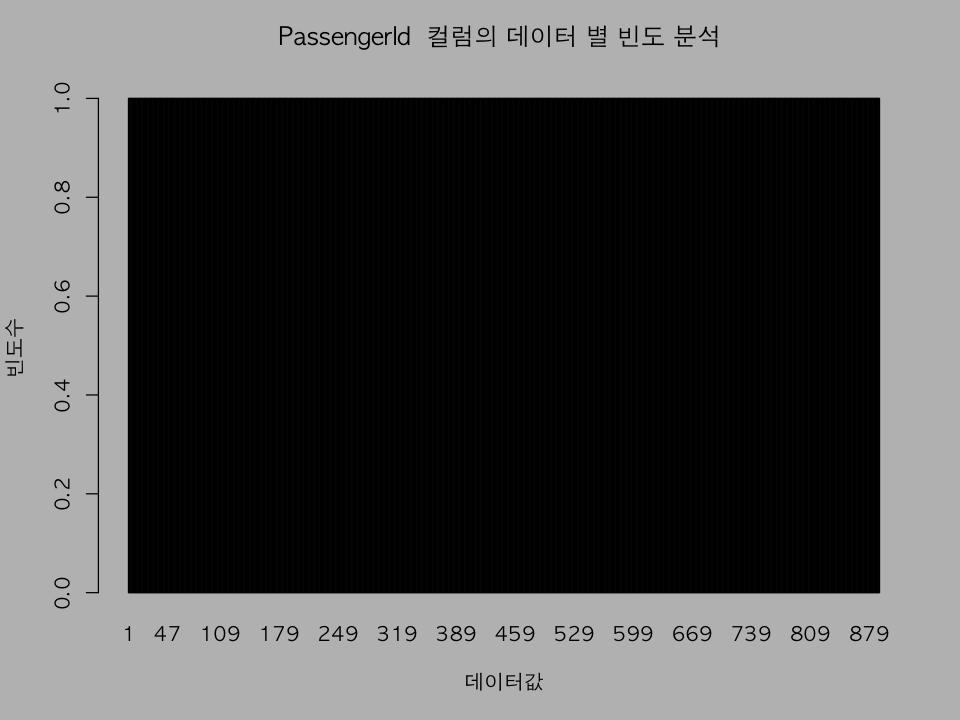


Survived 컬럼의 빈도수의 최대값과 최소값
최빈값: 491 최소빈도값 : 184 


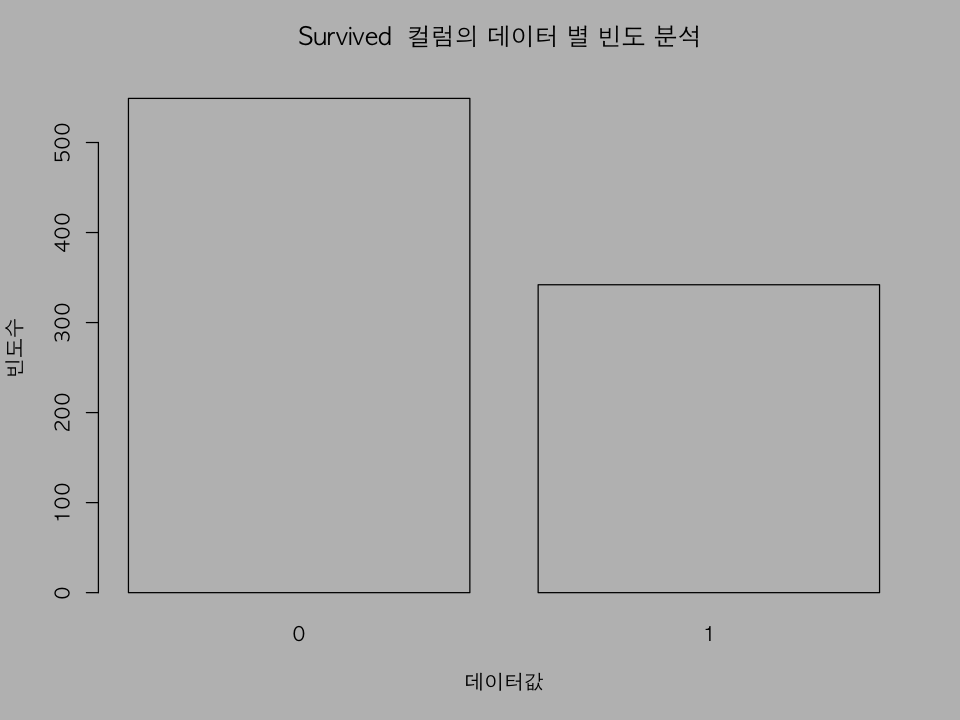


Pclass 컬럼의 빈도수의 최대값과 최소값
최빈값: 1 최소빈도값 : 1 


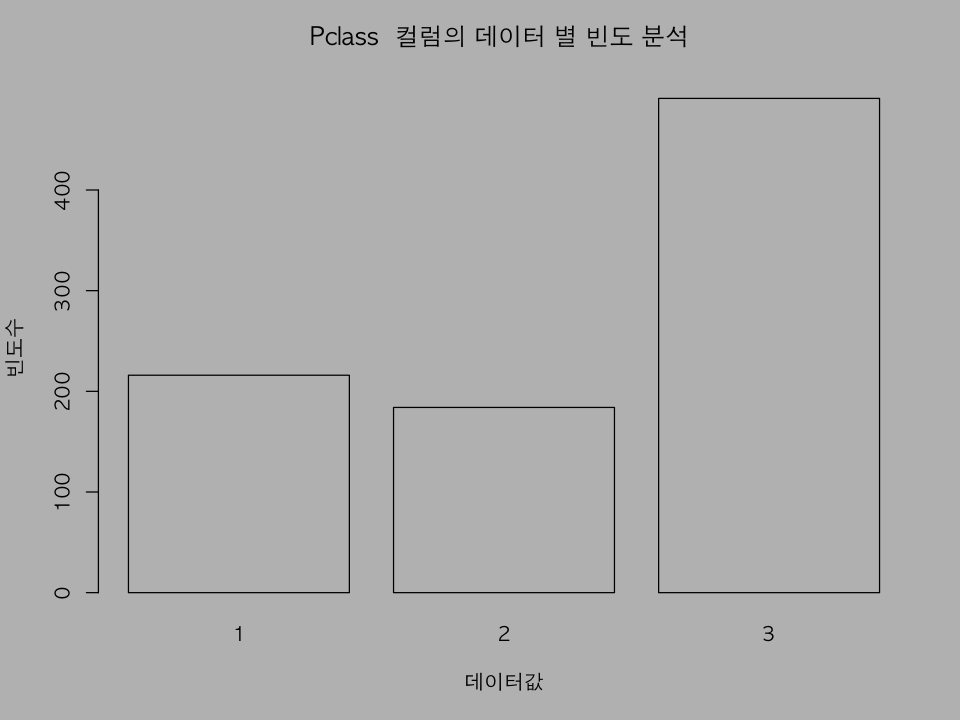


Name 컬럼의 빈도수의 최대값과 최소값
최빈값: 577 최소빈도값 : 314 


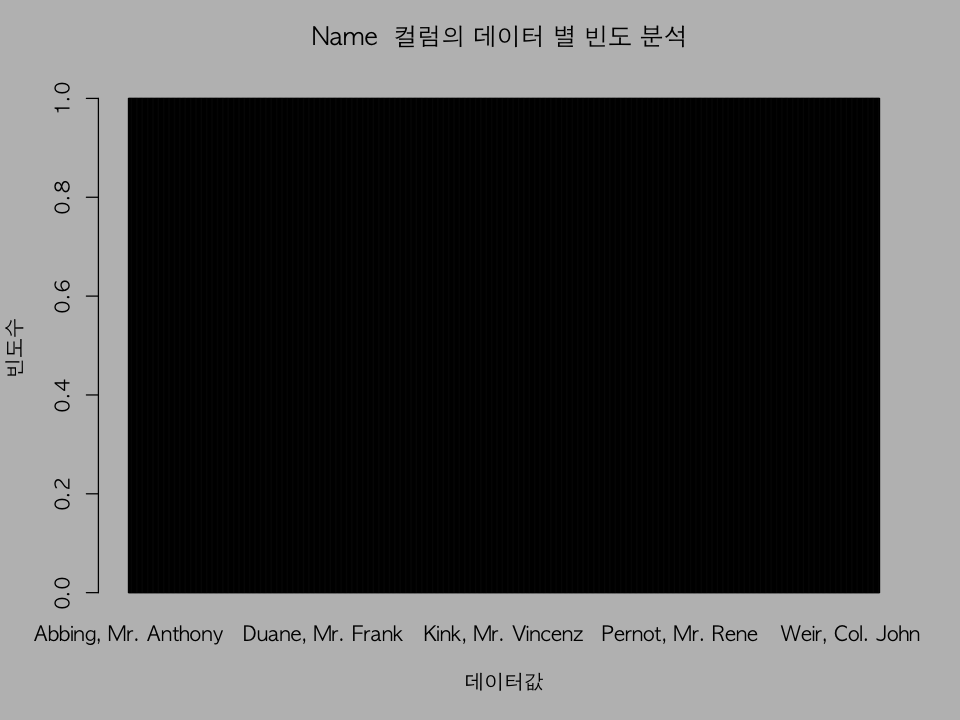


Sex 컬럼의 빈도수의 최대값과 최소값
최빈값: 30 최소빈도값 : 1 


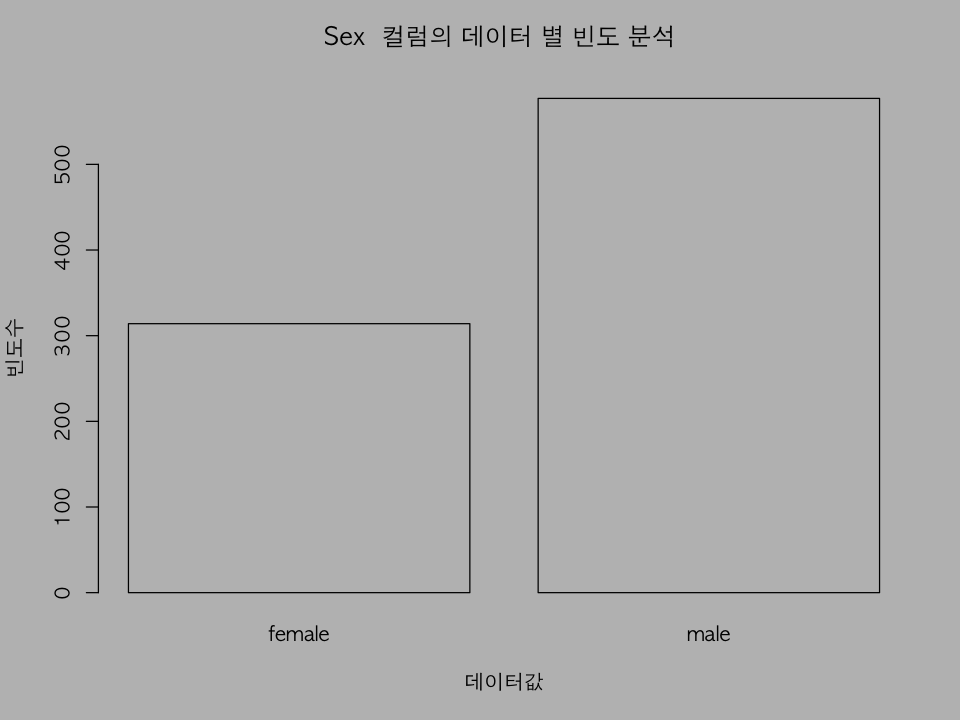


Age 컬럼의 빈도수의 최대값과 최소값
최빈값: 608 최소빈도값 : 5 


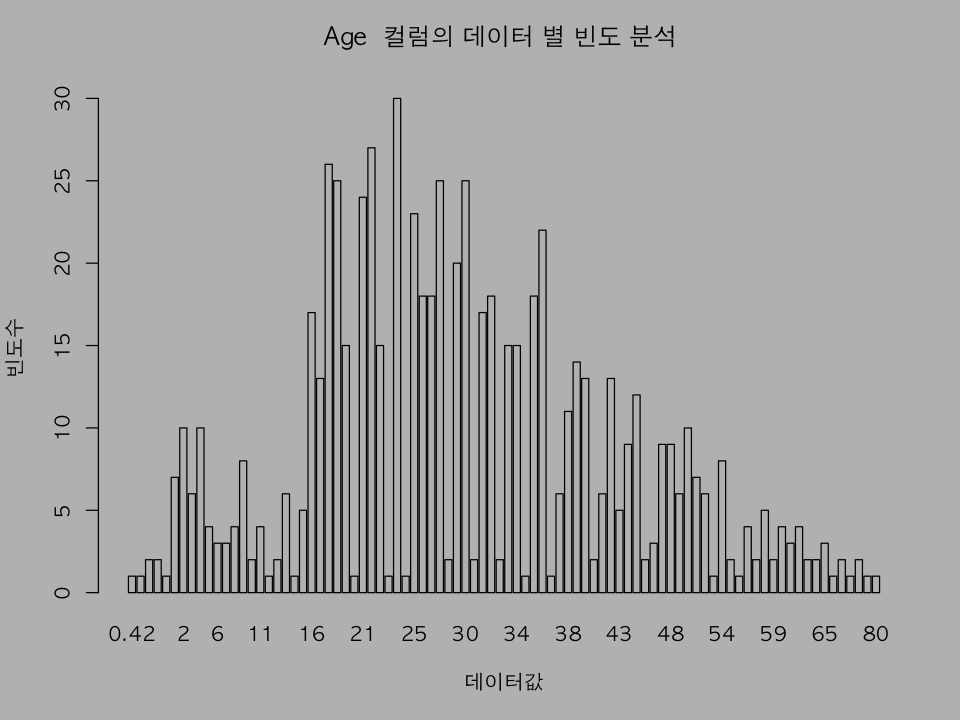


SibSp 컬럼의 빈도수의 최대값과 최소값
최빈값: 678 최소빈도값 : 1 


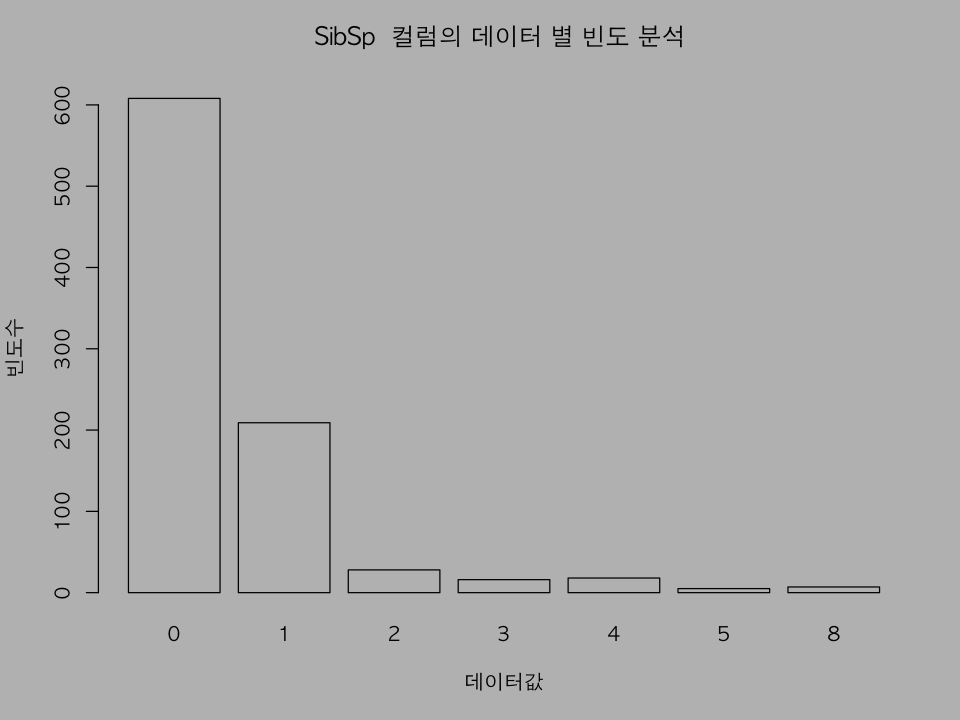


Parch 컬럼의 빈도수의 최대값과 최소값
최빈값: 7 최소빈도값 : 1 


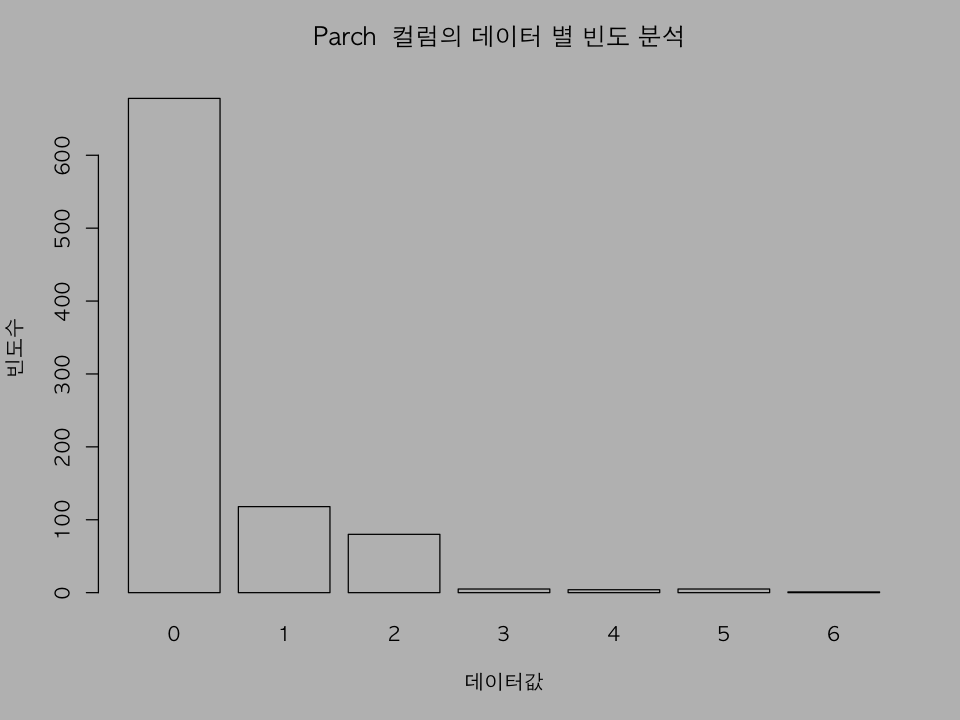


Ticket 컬럼의 빈도수의 최대값과 최소값
최빈값: 43 최소빈도값 : 1 


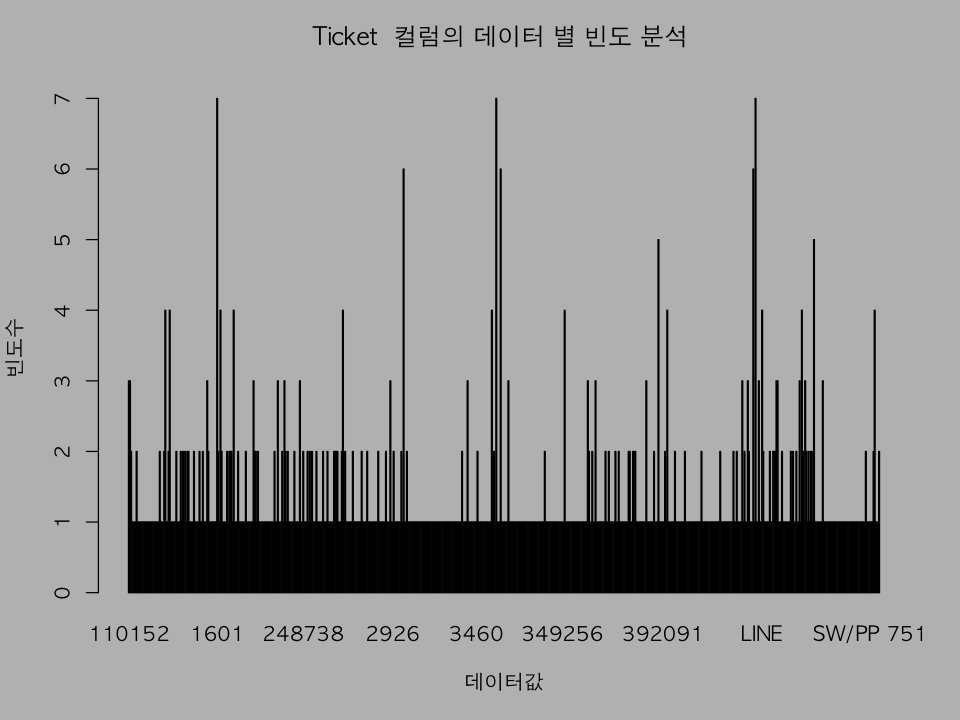


Fare 컬럼의 빈도수의 최대값과 최소값
최빈값: 687 최소빈도값 : 1 


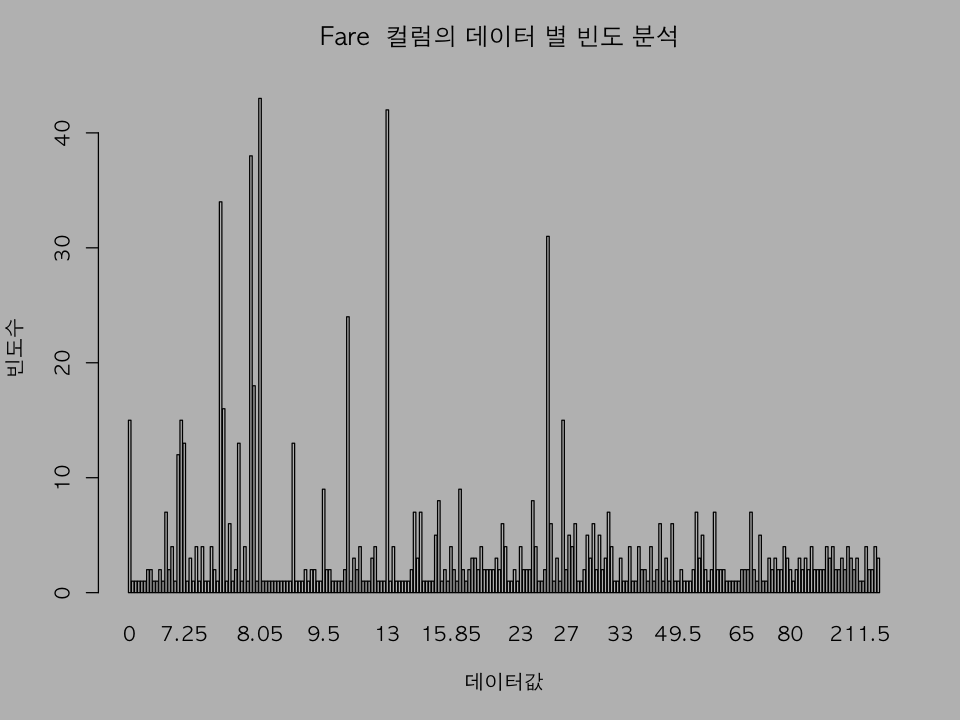


Cabin 컬럼의 빈도수의 최대값과 최소값
최빈값: 644 최소빈도값 : 2 


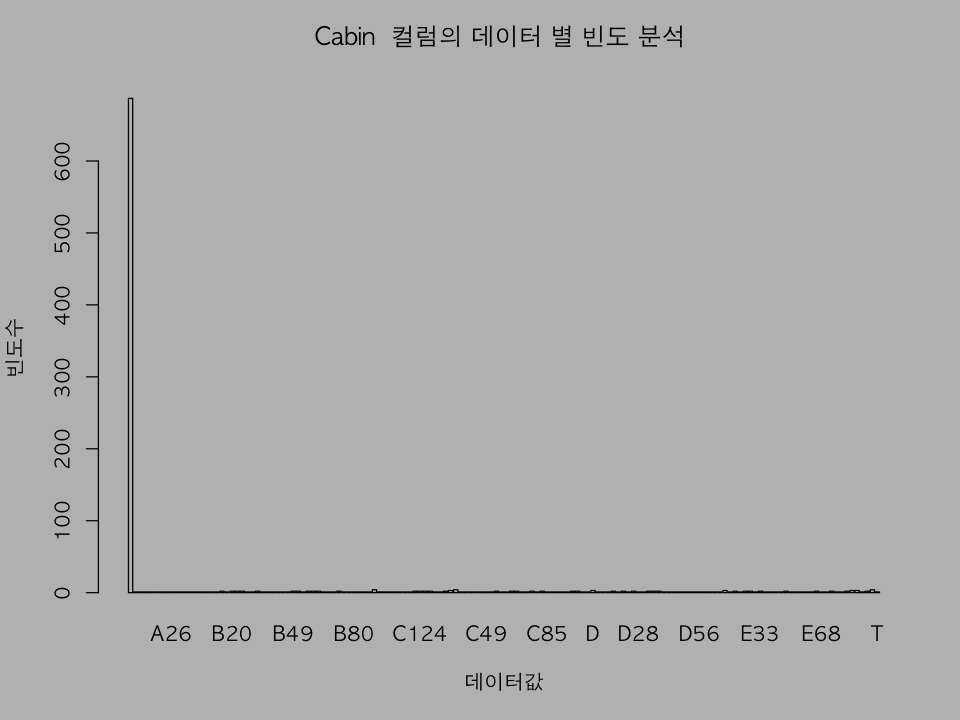


Embarked 컬럼의 빈도수의 최대값과 최소값


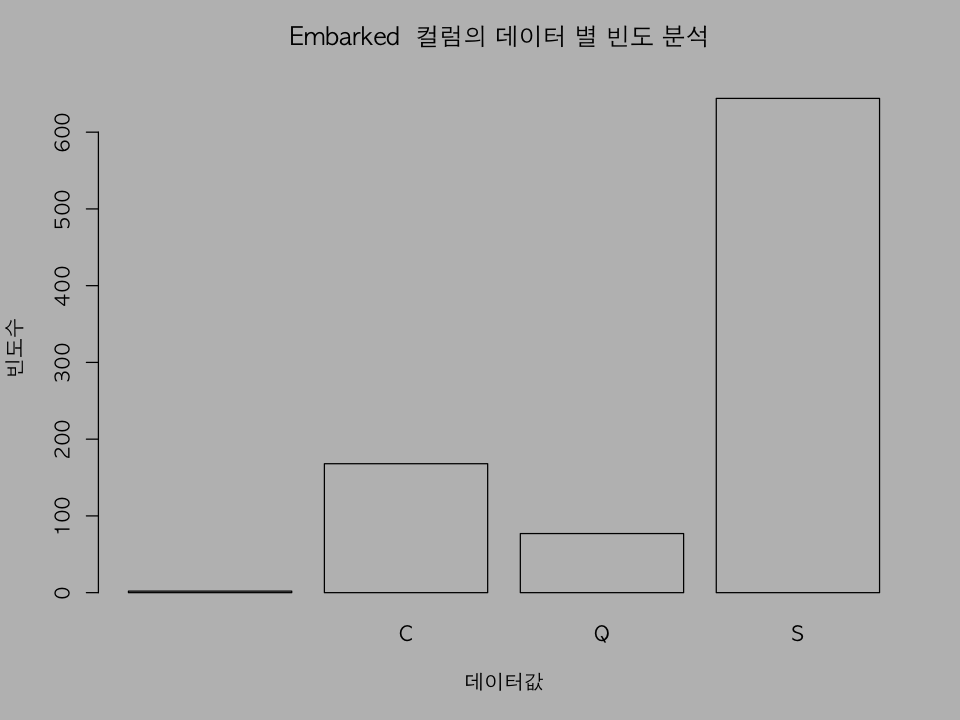

In [7]:
checkData(train_df)

In [8]:
colSums(is.na(train_df))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0

In [9]:
177/891 # 결측치 비율 20 이하는 의미가 없다. 

# train_df$Age 가 Na 인것 빼고 데이터 셋 만들기 or NA 인것만 가지고 해볼수잇음. 
subset( train_df, !is.na(train_df$Age))

[1] 0.1986532

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
7,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C


In [10]:
# Survived 기준으로 Dataset 정렬
arrange(train_df, desc(train_df$Survived))

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7000,G6,S
12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.5500,C103,S
16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55,0,0,248706,16.0000,,S
18,1,2,"Williams, Mr. Charles Eugene",male,NA,0,0,244373,13.0000,,S


# Target Column 성립?

In [11]:
# Survived 의 생존과 사망의 비율 검토
library(descr)
percent <- as.numeric(freq(train_df$Survived ,plot = F)[,2])[1:2]
count <- as.numeric(freq(train_df$Survived ,plot = F)[,1])[1:2]

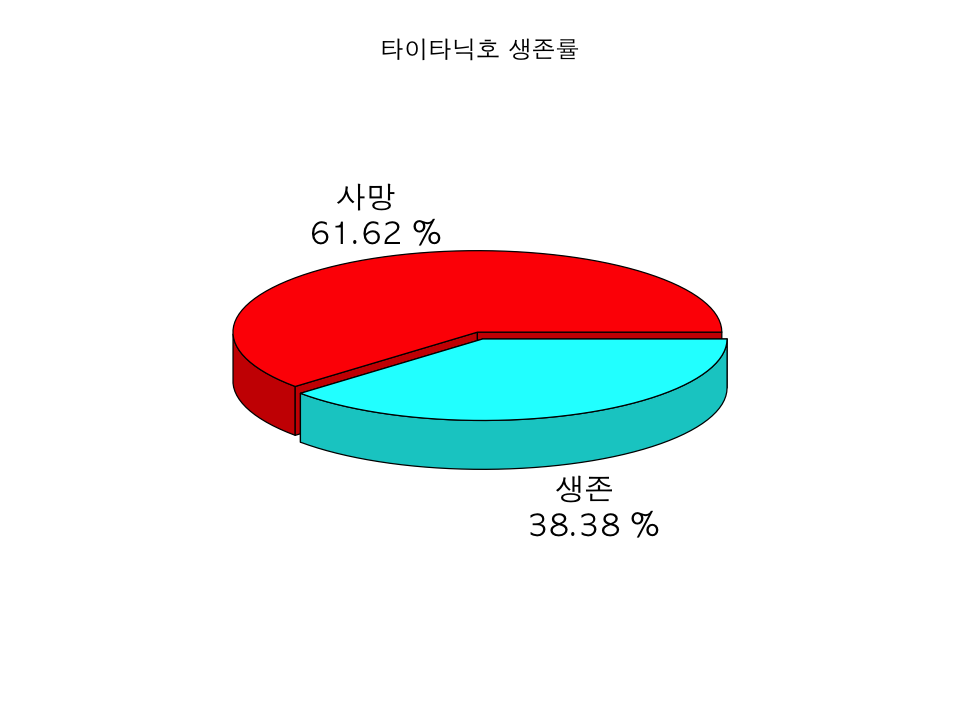

In [12]:
par(bg = 'white', family = 'AppleGothic')


label = paste(c("사망","생존"),"\n", round(percent,2),"%")
pie3D(percent,
        main ="타이타닉호 생존률",
        labels= label,
        explode =0.03
)


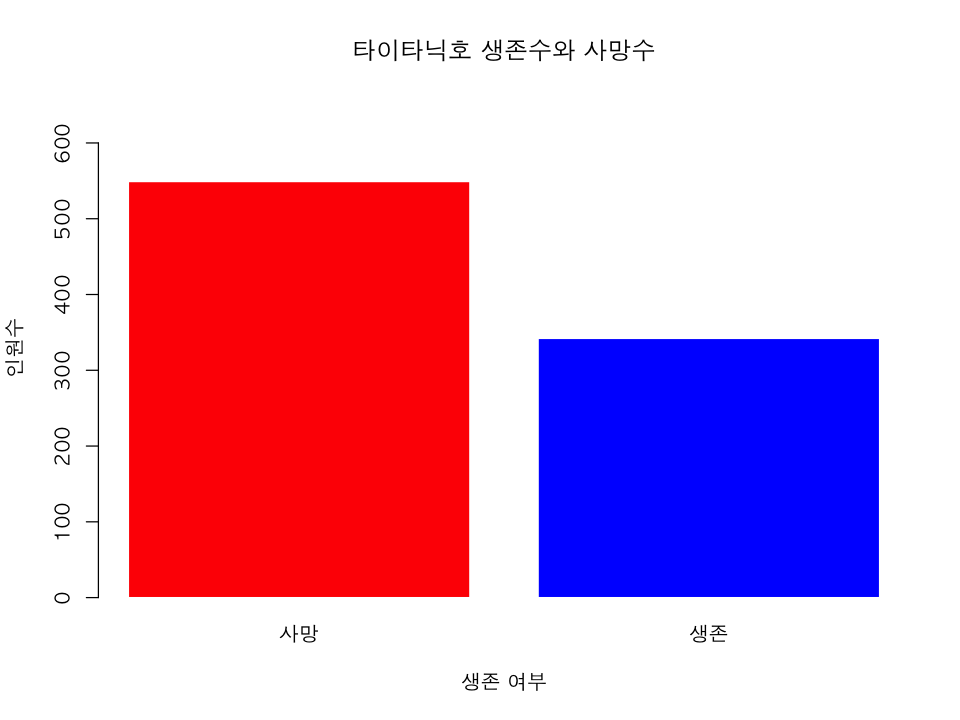

In [13]:
par(bg = 'white', family = 'AppleGothic')
barplot(count
    , col = c("red","blue"),
    names =c("사망","생존"),
    main ="타이타닉호 생존수와 사망수",
    ylim =c(0,max(count)*1.2),
    xlab = "생존 여부",
    ylab = "인원수",
    border =F
)

> Survived column 은 target DAta 로 적합하다.

# Feature 

In [14]:
head(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


In [15]:
# Sex 컬럼 분류 확인
unique(train_df$Sex)

[1] "male"   "female"

In [16]:
# feature 가 되려면 인원이 차이가 나야함. 
freq(train_df$Sex, plot =F)

,Frequency,Percent
female,314,35.2413
male,577,64.7587
Total,891,100.0000


,Freq.1,Freq.2
,<dbl>,<dbl>
0,25.79618,81.10919
1,74.20382,18.89081


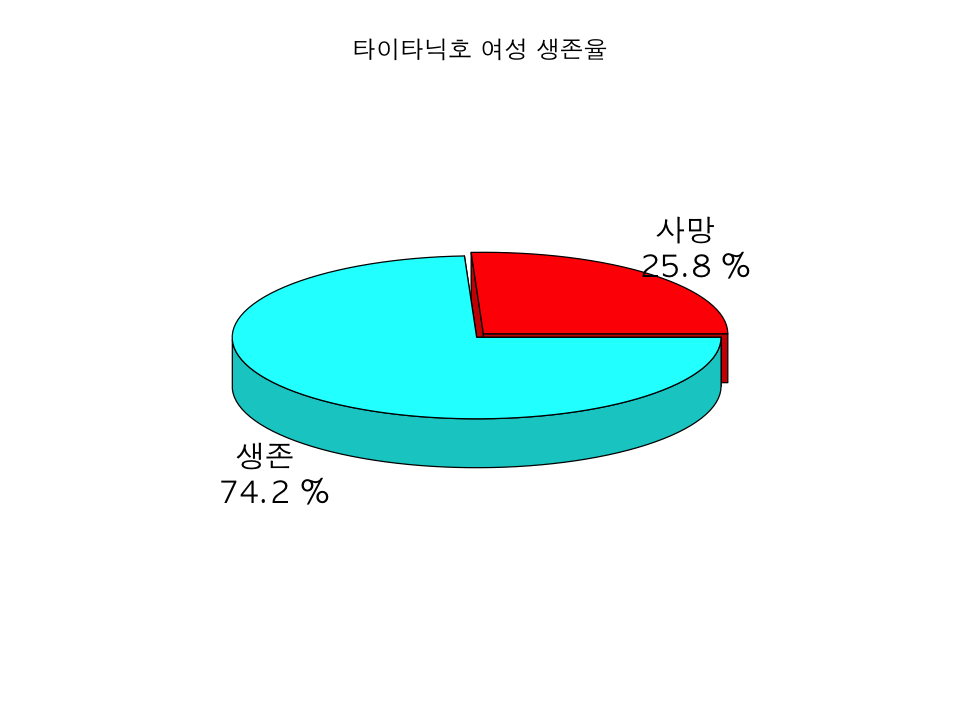

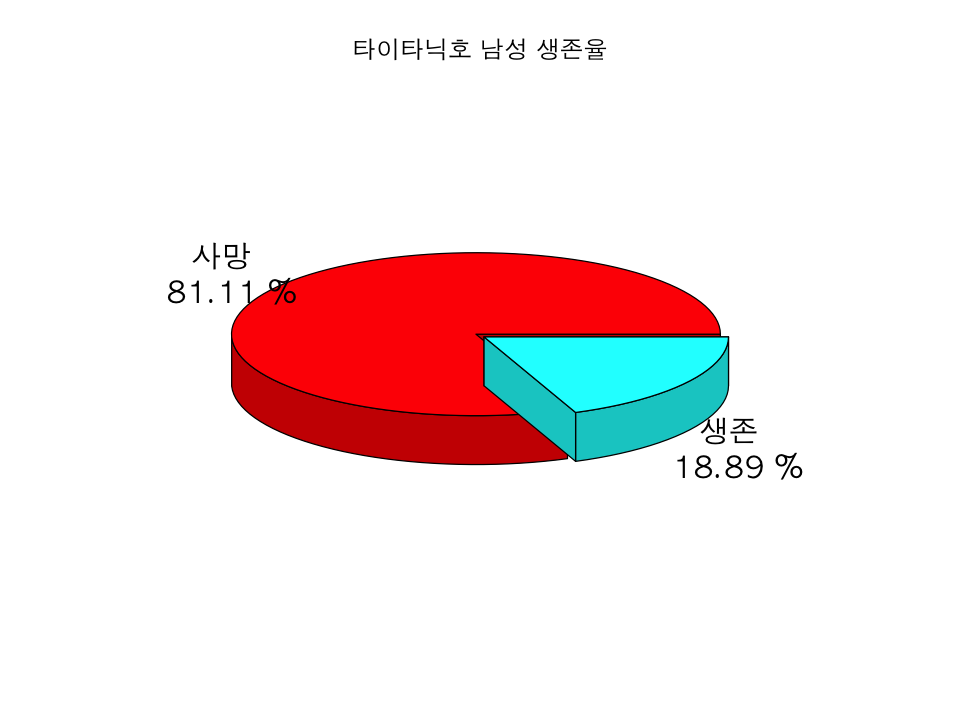

In [17]:
# 여성의 생존과 사망인원 
female<- subset(train_df , Sex =="female")
male<- subset(train_df , Sex =="male")

f<-freq(female$Survive, plot =F) # 74% : 233/314  
m<-freq(male$Survive, plot =F)   # 18% : 109/577  
fm <- data.frame( Freq= cbind(f[1:2,1], m[1:2,1]));colnames(fm)<-c("F","M")
fm_percent <- data.frame( Freq= cbind(f[1:2,2], m[1:2,2]));
fm_percent
colnames(fm_percent) <- c('F','M')
par(bg ='white', family = 'applegothic')

label_f <- paste(c("사망","생존"), "\n",round(fm_percent[,1],2),"%")
pie3D(fm_percent[,1],
        main ="타이타닉호 여성 생존율",
        labels =label_f,
        explode =0.02
)

label_m <- paste(c("사망","생존"), "\n",round(fm_percent[,2],2),"%")
pie3D(fm_percent[,2],
        main ="타이타닉호 남성 생존율",
        labels =label_m,
        explode =0.02
)



,F,M
,<dbl>,<dbl>
0,81,468
1,233,109


0   1 
549 342

F   M 
314 577

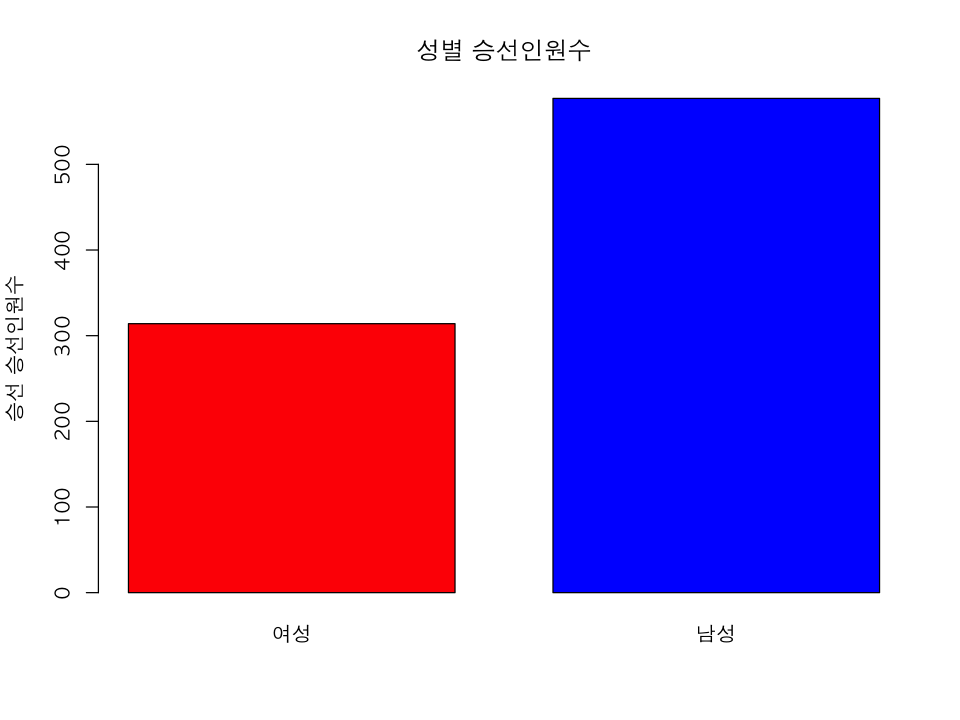

In [18]:
# 성별 승선 인원수 
fm
par(bg ='white', family = 'applegothic')
apply(fm,1,sum)
apply(fm,2,sum)

barplot(as.matrix(apply(fm,2,sum)), beside =T, col= c('red','blue'), names = c("여성","남성"),

    main = "성별 승선인원수",
    ylab = "승선 승선인원수",
    space =0.3
)


> [survived]<[died]>

In [19]:
head(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


# 티켓 등급 분석

In [20]:
# 티켓 등급 분류
table(train_df$Pclass)


  1   2   3 
216 184 491 

In [21]:
# 1등 객실의 여성 생존율 
head(train_df)
PClass01_FeLive<-freq(subset(train_df, select= c("Survived","Pclass","Sex"), Sex =='female'& Pclass ==1)$Survived, plot =F)
PClass02_FeLive<-freq(subset(train_df, select= c("Survived","Pclass","Sex"), Sex =='female'& Pclass ==2)$Survived, plot =F)
PClass03_FeLive<-freq(subset(train_df, select= c("Survived","Pclass","Sex"), Sex =='female'& Pclass ==3)$Survived, plot =F)

PClass01_FeLive
cat( "\n1등 객실의 여성 생존율은 ",PClass01_FeLive[2,1],"/",PClass01_FeLive[3,1],":",round(PClass01_FeLive[2,2],2),"%")
cat( "\n2등 객실의 여성 생존율은 ",PClass02_FeLive[2,1],"/",PClass02_FeLive[3,1],":",round(PClass02_FeLive[2,2],2),"%")
cat( "\n3등 객실의 여성 생존율은 ",PClass03_FeLive[2,1],"/",PClass03_FeLive[3,1],":",round(PClass03_FeLive[2,2],2),"%")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


,Frequency,Percent
0,3,3.191489
1,91,96.808511
Total,94,100.000000



1등 객실의 여성 생존율은  91 / 94 : 96.81 %
2등 객실의 여성 생존율은  70 / 76 : 92.11 %
3등 객실의 여성 생존율은  72 / 144 : 50 %

In [22]:
# 1,2,3등 객실의 여성 생존율 (for)
head(train_df)
for( i in 1:3){
                PClass_FeLive<-freq(subset(train_df, 
                                    select= c("Survived","Pclass","Sex"), # col select
                                    Sex =='female'& Pclass ==i)$Survived, # row select
                                    plot =F)
cat( "\n",i,"등 객실의 여성 생존율은 ",
            PClass_FeLive[2,1],"/",PClass_FeLive[3,1],":",round(PClass_FeLive[2,2],2),"%")
}

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q



 1 등 객실의 여성 생존율은  91 / 94 : 96.81 %
 2 등 객실의 여성 생존율은  70 / 76 : 92.11 %
 3 등 객실의 여성 생존율은  72 / 144 : 50 %


 1 등 객실의 남성 생존율은  45 / 122 : 36.89 % 
 2 등 객실의 남성 생존율은  17 / 108 : 15.74 % 
 3 등 객실의 남성 생존율은  47 / 347 : 13.54 % 
 1 등 객실의 여성 생존율은  91 / 94 : 96.81 % 
 2 등 객실의 여성 생존율은  70 / 76 : 92.11 % 
 3 등 객실의 여성 생존율은  72 / 144 : 50 % 

[1] "1객실(남)" "2객실(남)" "3객실(남)" "1객실(여)" "2객실(여)" "3객실(여)"

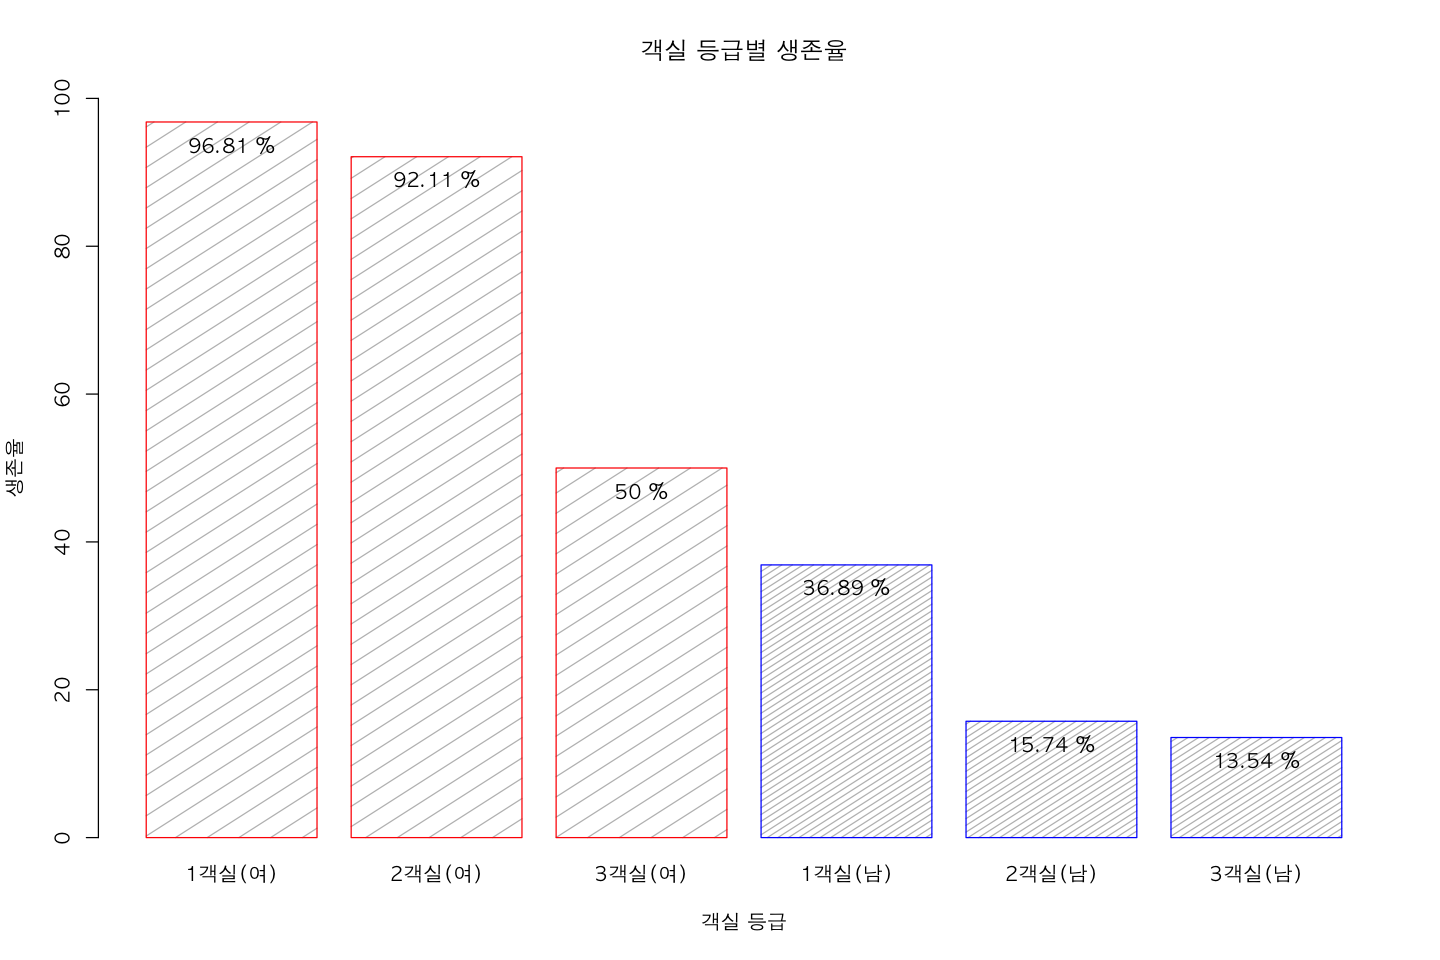

In [23]:
# 1,2,3등 객실의 남성과 여성생존율을 for문을 통해 해결


livePercent<-c()
lP_name<- c()
for( sex in c("male","female")){
    for( i in 1:3){
            PClass_FeLive<-freq(subset(train_df, 
                                    select= c("Survived","Pclass","Sex"), # col select
                                    Sex == sex & Pclass ==i)$Survived, # row select
                                    plot =F)
            PClass_MaLive<-freq(subset(train_df, 
                                    select= c("Survived","Pclass","Sex"), # col select
                                    Sex == sex & Pclass ==i)$Survived, # row select
                                    plot =F)
            
            cat( "\n",i,"등 객실의",ifelse(sex=='male','남성','여성'),"생존율은 ",
                PClass_FeLive[2,1],"/",PClass_FeLive[3,1],":",round(PClass_FeLive[2,2],2),"%", seq="")

            livePercent<-append(livePercent,round(PClass_FeLive[2,2],2))
            lP_name <-append(lP_name,paste(i,"객실", "(",ifelse(sex=='male','남','여')  ,")",sep=""))
            
    }
}
lP_name
names(livePercent)<- lP_name
par(bg ="white", family= 'applegothic')
options(repr.plot.width = 12, repr.plot.height =8)
barplot(sort(livePercent, decreasing =T),
        density =c(rep(10,3),rep(30,3)),
        border = c(rep("red",3),rep("blue",3)),
        ylim=c(0,100),
        main = "객실 등급별 생존율",
        ylab = "생존율",
        xlab = "객실 등급"
)
#text(c(seq(0.7,7,1.2)),sort(livePercent, decreasing =T)-3,paste(sort(livePercent, decreasing =T),"%"))
text(c(1.2*0:5+0.7),sort(livePercent, decreasing =T)-3,paste(sort(livePercent, decreasing =T),"%"))

In [24]:
head(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


# Embarked

In [25]:
unique(train_df$Embarked)

table(train_df$Embarked)
# 빈칸의 데이터 찾기 
subset(train_df, Embarked =="")

[1] "S" "C" "Q" ""


      C   Q   S 
  2 168  77 644 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
62,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,
830,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,


In [26]:
# 항구별 탑승인원수를 구하여 가장 많은 탑승인원의 항구로 결정
# S 항구 644
# C 항구 168
# Q 항구 77
# 빈칸 항구 찾기 -1
# 복사본 만들기 
train_df_T <-train_df
subset(train_df_T, Embarked =="")
# 빈칸 항구 찾기 -2
#train_df_T[train_df_T$Embarked == ""]

train_df_T$Embarked <- ifelse(train_df_T$Embarked=="", 'S',train_df_T$Embarked);

train_df_T[train_df_T$Embarked == ""]

# 2개 행 만 건드리는 법.
train_df_T[train_df_T$Embarked =="",]$Embarked <-'S'

#substrain_df <-train_df_T
table(train_df$Embarked)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
62,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,
830,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,


1  
2  
3  
4  
5  
6  
7  
8  
9  
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
...
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891

ERROR: Error in `$<-.data.frame`(`*tmp*`, Embarked, value = "S"): replacement has 1 row, data has 0


In [ ]:
train_df <-train_df_T
table(train_df$Embarked)




  C   Q   S 
168  77 646 

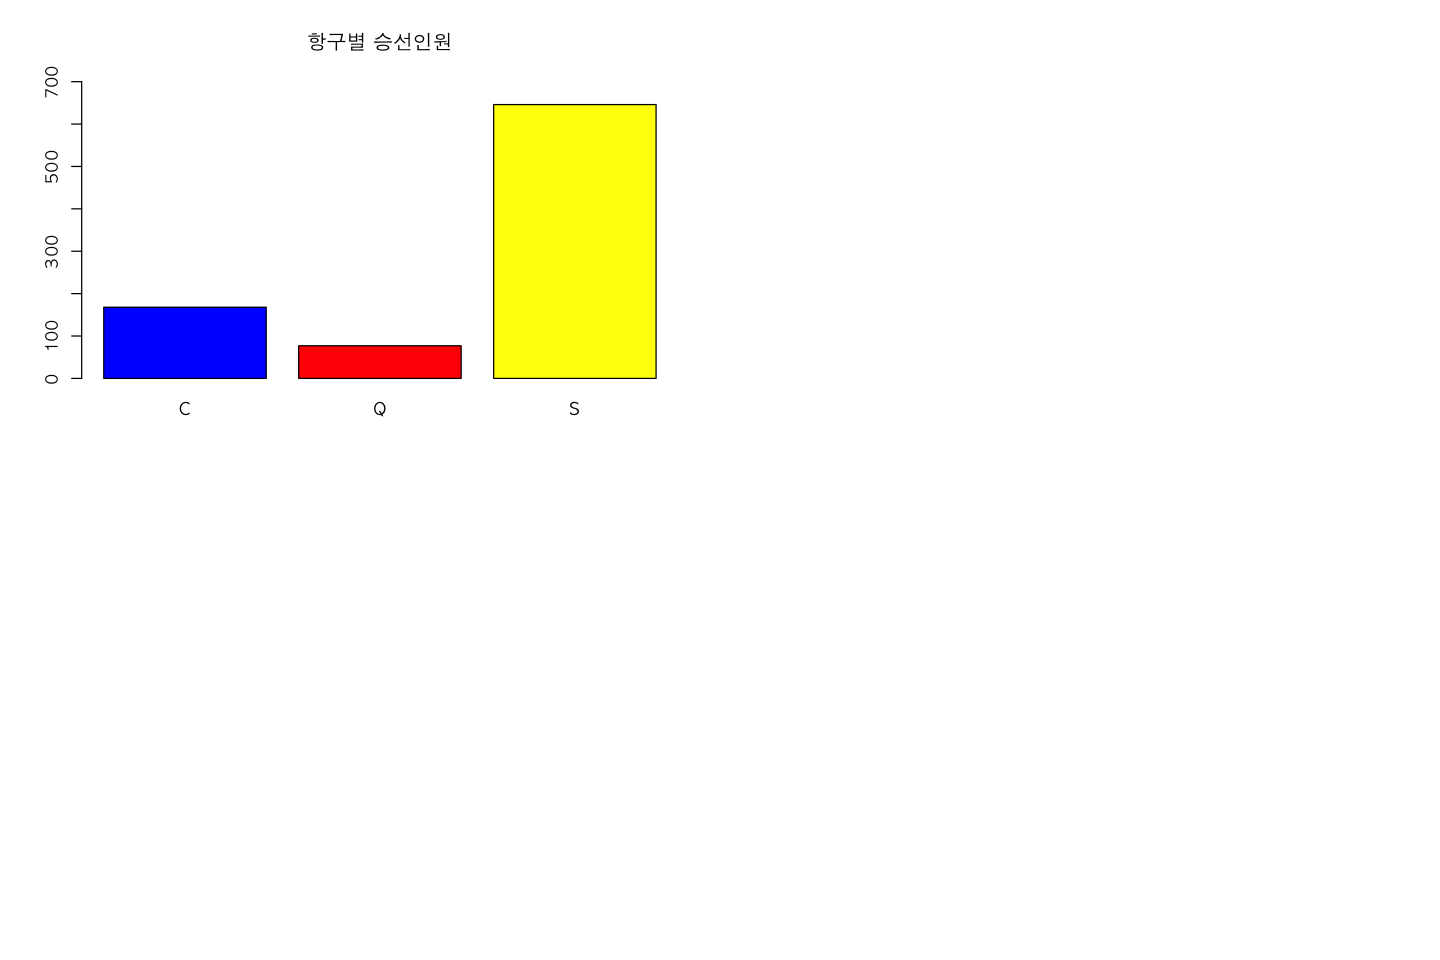

In [ ]:
par(bg ="white", family ="applegothic")

barplot(table(train_df$Embarked)

,main = "항구별 승선인원"
,col =c("blue","red","yellow")
,ylim =c(0,700)
)


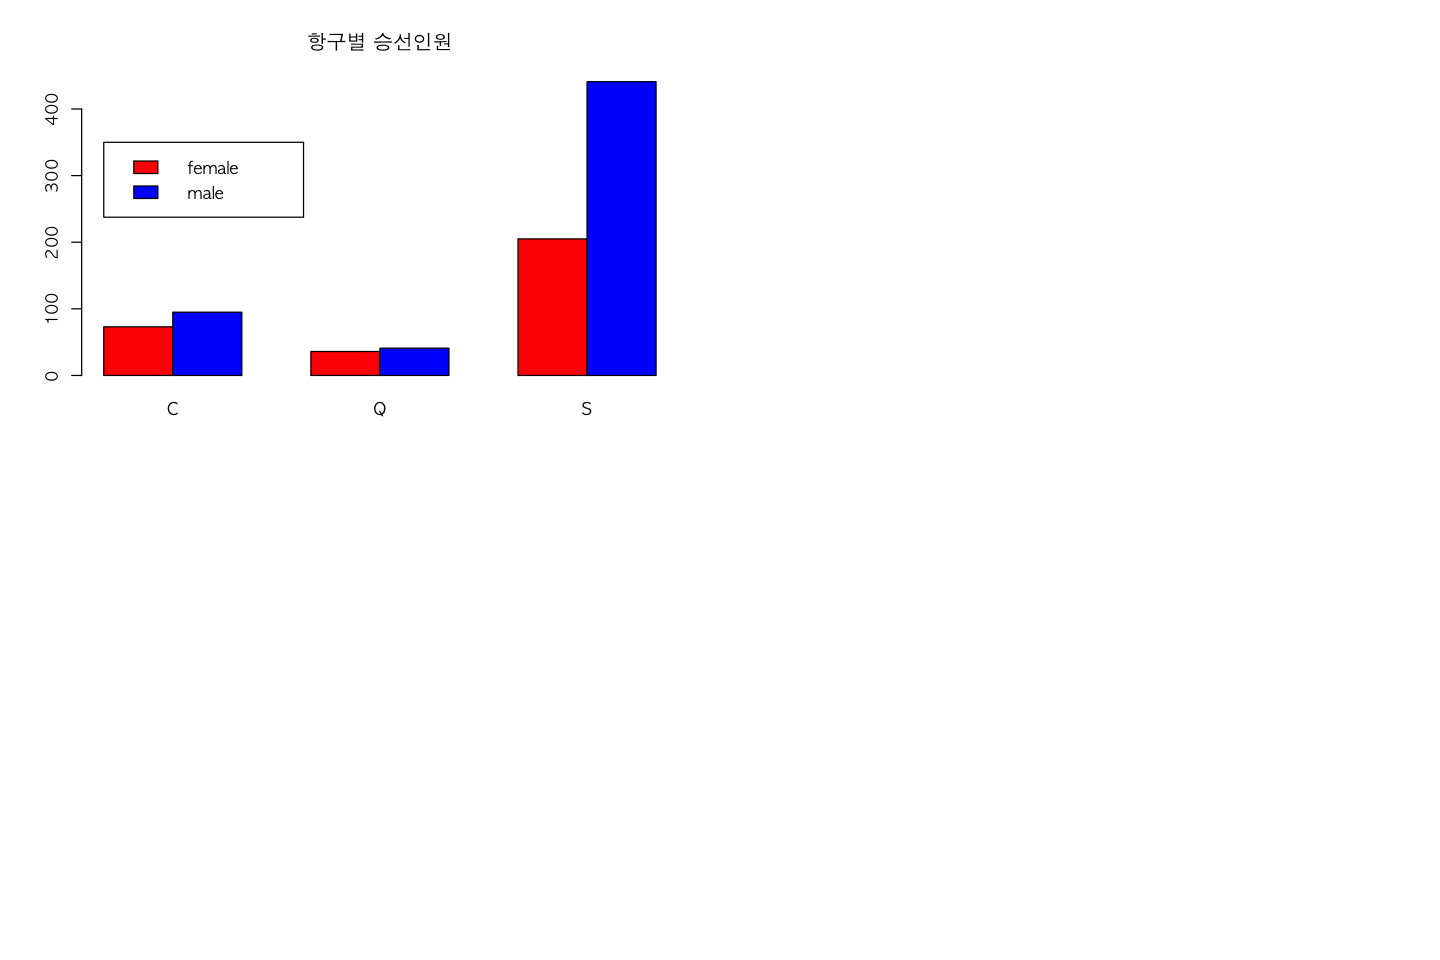

In [ ]:
par(bg ="white",family ="applegothic")


barplot(table(train_df$Sex,train_df$Embarked),beside =T
,col =c("red","blue"), main = "항구별 승선인원")

legend(1,350, c("female","male"),fill =c("red","blue"))

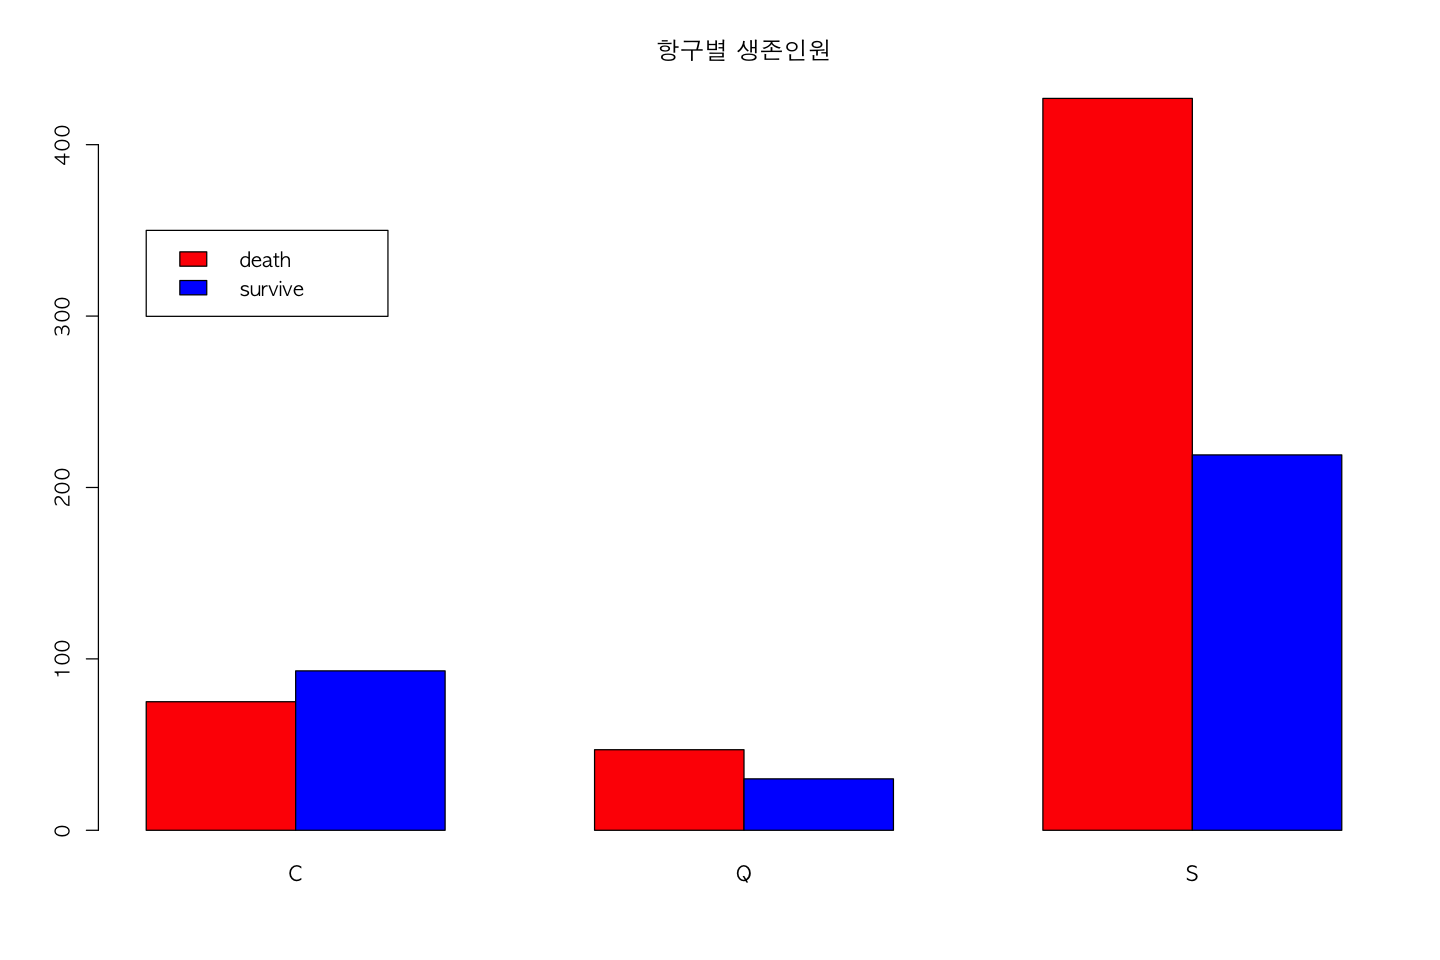

In [ ]:
par(bg ="white",family ="applegothic")
barplot(table(train_df$Survived,train_df$Embarked),beside =T
,col =c("red","blue"), main = "항구별 생존인원")

legend(1,350, c("death","survive"),fill =c("red","blue"))

   
      C   Q   S
  1  85   2 129
  2  17   3 164
  3  66  72 353

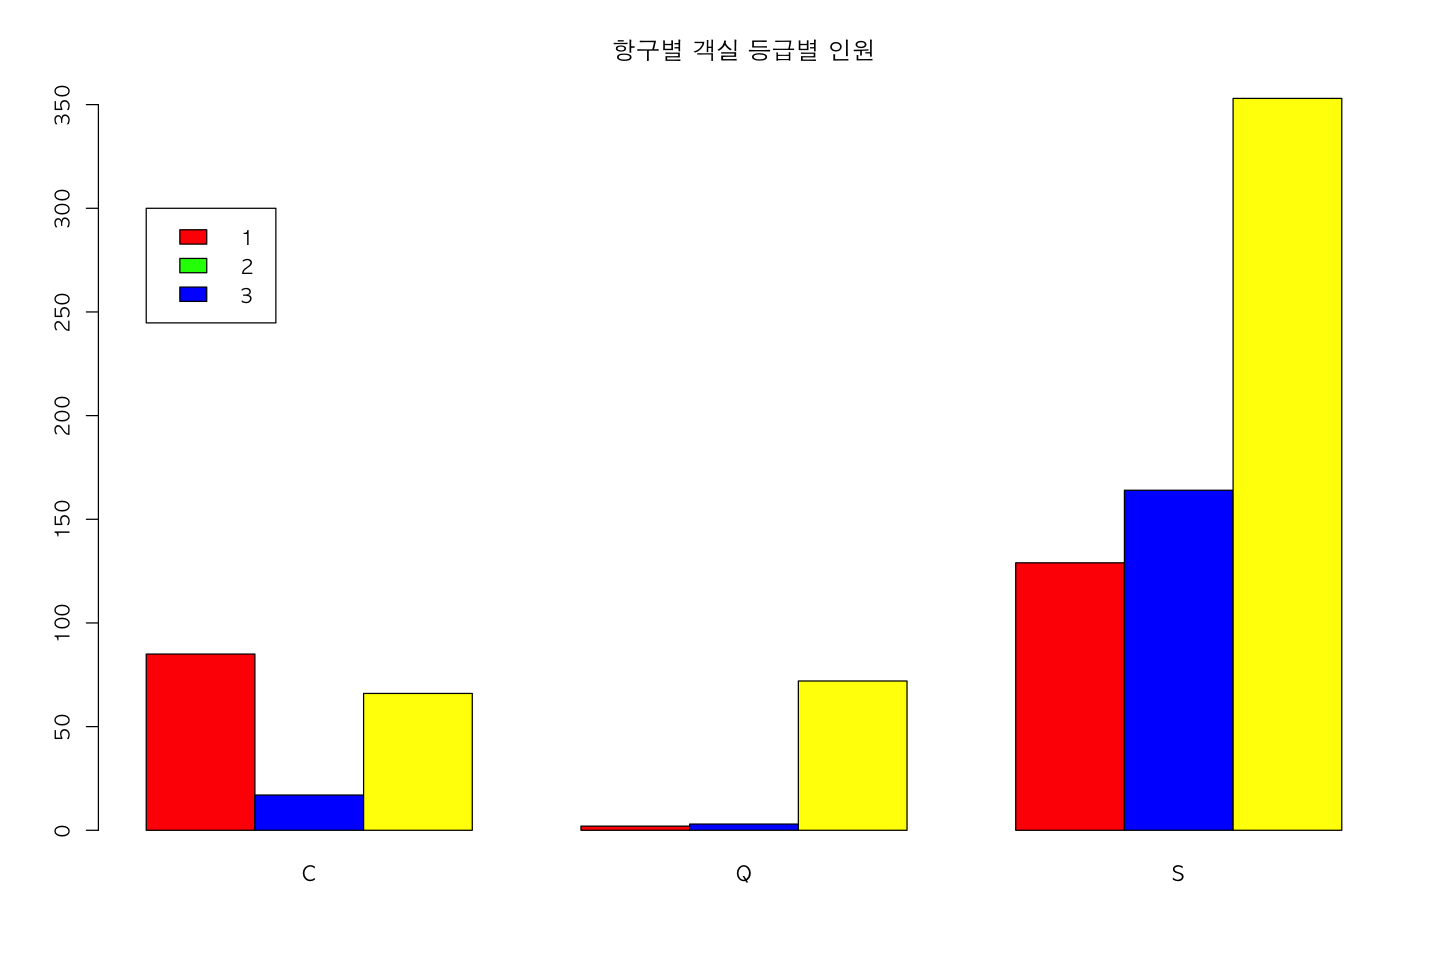

In [ ]:
# 항구별 객실 등급별 인원
par(family = "applegothic", bg ='white')
table(train_df$Pclass,train_df$Embarked)
barplot(table(train_df$Pclass,train_df$Embarked),beside =T, col = c("red","blue","yellow"),
        main="항구별 객실 등급별 인원")
legend(1,300,c(1,2,3),fill = rainbow(3))

   
      C   Q   S
  1  85   2 129
  2  17   3 164
  3  66  72 353

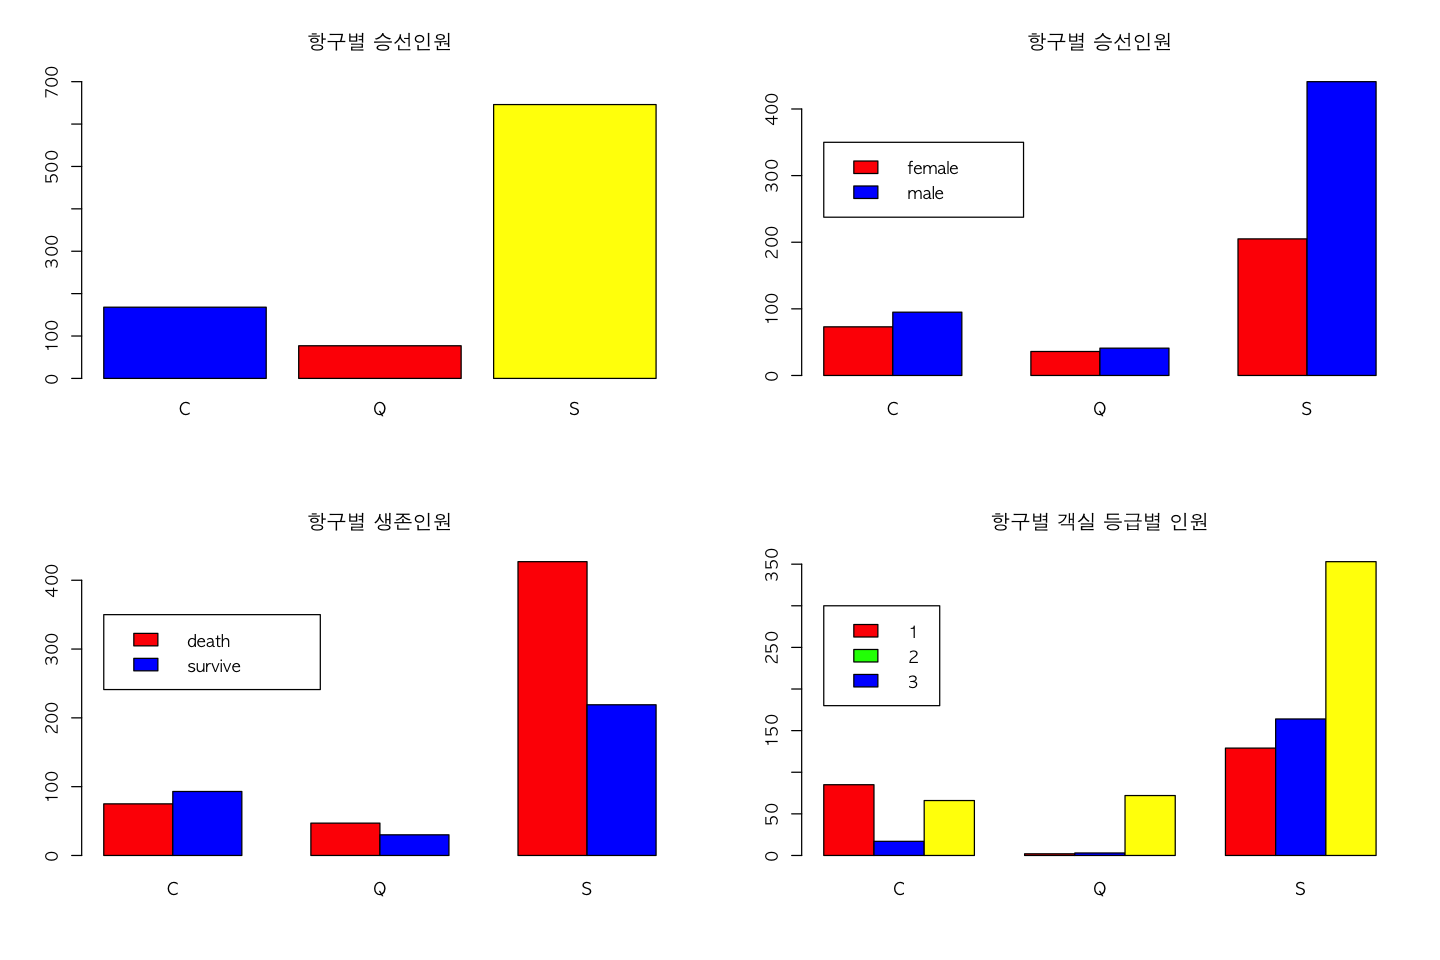

In [ ]:
par( mfrow =c(2,2))

par(bg ="white", family ="applegothic")

barplot(table(train_df$Embarked)

,main = "항구별 승선인원"
,col =c("blue","red","yellow")
,ylim =c(0,700)
)

par(bg ="white",family ="applegothic")


barplot(table(train_df$Sex,train_df$Embarked),beside =T
,col =c("red","blue"), main = "항구별 승선인원")

legend(1,350, c("female","male"),fill =c("red","blue"))

par(bg ="white",family ="applegothic")
barplot(table(train_df$Survived,train_df$Embarked),beside =T
,col =c("red","blue"), main = "항구별 생존인원")

legend(1,350, c("death","survive"),fill =c("red","blue"))
# 항구별 객실 등급별 인원
par(family = "applegothic", bg ='white')
table(train_df$Pclass,train_df$Embarked)
barplot(table(train_df$Pclass,train_df$Embarked),beside =T, col = c("red","blue","yellow"),
        main="항구별 객실 등급별 인원")
legend(1,300,c(1,2,3),fill = rainbow(3))



> 절반이상의 승객이 southampton에서 배를 탔으며 여기에서 탑승한 승객의 70% 가 남성이었으며 <br>
남성의 사망율이 여성보다 훨씬 높았으므로 사우샘프턴의 사망율이 높게 나왔으며<br>
사우스샘프턴에서 탑승한 승객의 60%이상이 3등급 객실을 사용햇따. <br>
chersbourg에서 탑승한 승객들은 1등 객실 비중 및 생존율이 높은것으로 보아 이 동네는 부자 동네이다. <br>

In [ ]:
cor(train_df$Survived,train_df$Pclass)

[1] -0.338481

[Survived] <- [Sex,Pclass,Embarked]

classfication 이 중요함. 
성별, 등급, 승차한 항구  순으로 영향력이있는 칼럼을 분석해보았다. 
타겟과 하나씩 연결하면서  차트를 보면된다. <- 포폴에는 차트와 그래프가 있어야함. 
EDA ( 필요한 항목인지 아닌지 확인 할것. )
구명선 레이디, 베이비 를 찾는 것이 중요. 
에이지를 가지고 년도별로 카테고리화해서 쓸것. => Kmeans 로 카테고리화. ??
Age에 는 NA 가 있다. NA 를 어떤값으로 대체할것인가? <-  생존하면 특정값을 넣을수잇게?
fare 도 k means 로 카테고리화 할것인가 아니면 그냥 숫자로 넣을것이냐.. 여러가지 아이디어 

발표는 5시 10분 

In [27]:
train_df_T <-train_df

In [28]:
target_col <-c("Survived","Sex","Pclass","Embarked")
head(train_df_T[,target_col])

,Survived,Sex,Pclass,Embarked
,<int>,<chr>,<int>,<chr>
1,0,male,3,S
2,1,female,1,C
3,1,female,3,S
4,1,female,1,S
5,0,male,3,S
6,0,male,3,Q


In [32]:
# 성별을 숫자로 전환
train_df_T$SexCode[train_df_T$Sex =="male"]<-0
train_df_T$SexCode[train_df_T$Sex =="female"]<-1


In [35]:
target_col <-c("Survived","SexCode","Pclass","Embarked")
head(train_df_T[,target_col])

,Survived,SexCode,Pclass,Embarked
,<int>,<dbl>,<int>,<chr>
1,0,0,3,S
2,1,1,1,C
3,1,1,3,S
4,1,1,1,S
5,0,0,3,S
6,0,0,3,Q


In [36]:
train_df_T$Embarked_C <- train_df_T$Embarked =="C"
train_df_T$Embarked_S <- train_df_T$Embarked =="S"
train_df_T$Embarked_Q <- train_df_T$Embarked =="Q"

In [38]:
target_col <-c("Survived","SexCode","Pclass","Embarked","Embarked_C","Embarked_S","Embarked_Q")
head(train_df_T[,target_col])

,Survived,SexCode,Pclass,Embarked,Embarked_C,Embarked_S,Embarked_Q
,<int>,<dbl>,<int>,<chr>,<lgl>,<lgl>,<lgl>
1,0,0,3,S,FALSE,TRUE,FALSE
2,1,1,1,C,TRUE,FALSE,FALSE
3,1,1,3,S,FALSE,TRUE,FALSE
4,1,1,1,S,FALSE,TRUE,FALSE
5,0,0,3,S,FALSE,TRUE,FALSE
6,0,0,3,Q,FALSE,FALSE,TRUE


In [40]:
# Machine Learning 작업을 위한 최종 feature
target_col <-c("Survived","SexCode","Pclass","Embarked_C","Embarked_S","Embarked_Q")
head(train_df_T[,target_col])

,Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q
,<int>,<dbl>,<int>,<lgl>,<lgl>,<lgl>
1,0,0,3,FALSE,TRUE,FALSE
2,1,1,1,TRUE,FALSE,FALSE
3,1,1,3,FALSE,TRUE,FALSE
4,1,1,1,FALSE,TRUE,FALSE
5,0,0,3,FALSE,TRUE,FALSE
6,0,0,3,FALSE,FALSE,TRUE


In [42]:
train_df2 <- train_df_T[,target_col]
head(train_df2)

,Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q
,<int>,<dbl>,<int>,<lgl>,<lgl>,<lgl>
1,0,0,3,FALSE,TRUE,FALSE
2,1,1,1,TRUE,FALSE,FALSE
3,1,1,3,FALSE,TRUE,FALSE
4,1,1,1,FALSE,TRUE,FALSE
5,0,0,3,FALSE,TRUE,FALSE
6,0,0,3,FALSE,FALSE,TRUE


In [49]:
# RandomForest 생사여부 예측률과 오분류표 구하기 
# RandomForrest Prediction
rfFunc <- function(data,target_col,rf_n,iter_n){
    Sys.setlocale(category = "LC_ALL", locale = "ko_KR.UTF-8") # 한글 설정
    target <- data[,target_col] # target 칼럼
    acc_rf <-c()
    acc_nn <-c()
    cat("예측률 \n")

    for(i in 1:iter_n){
        samp <- createDataPartition(data[,target_col], p =0.7, list =F)
        # 학습용, 검증용 분류
        data.tr     <- data[samp,]
        data.test   <- data[-samp,]
        # 문제 및 정답 만들기 
        x <- subset(data.test, select = -target_col)
        y <- data.test[,target_col]
        
        # 모델 생성
        target_name     <-colnames(data)[target_col] 
        Training_target <-data.frame(Survived=data.tr[,target_col])

        #model.nnet <- nnet(Training_target$V1 ~ ., data =data.tr, size = 3, trace =F) 

        rf <- randomForest(Training_target$Survived ~ ., data =data.tr, ntree =rf_n)
        # 예측
        pred_rf <-predict(rf,x )
        #pred_nn <-predict(model.nnet,x )
        acc_rf<-append(acc_rf,mean(pred_rf == y))
        #acc_nn<-append(acc_nn,mean(pred_nn == y))
        cat(mean(pred_rf ==y)," ")
    }
    cat("\n\033[36m Random Forest 평균 예측률 : ",mean(acc_rf) ,"\033[0m",sep = "")
    #cat("\n\033[36m Neural Network 평균 예측률 : ",mean(acc_nn) ,"\033[0m",sep = "")
    #return(mean(acc))
}

# data,target_col,rf_n,iter_n
train_df2$Survived<- as.factor(train_df2$Survived)
rfFunc(train_df2,1,100,5)


예측률 
0.8045113  0.8383459  0.7819549  0.8157895  0.8308271  
 Random Forest 평균 예측률 : 0.8142857

In [81]:
ageNa<- filter(train_df, is.na(train_df$Age))
#ageNa

train_df_age<- filter(train_df, !is.na(train_df$Age))

# 연령대 
sort(unique(train_df_age$Age), decreasing = T) # Max 80, min : 0.42 
stem(train_df_age$Age, scale =1) # 연령대 분포 


[1] 80.00 74.00 71.00 70.50 70.00 66.00 65.00 64.00 63.00 62.00 61.00 60.00
[13] 59.00 58.00 57.00 56.00 55.50 55.00 54.00 53.00 52.00 51.00 50.00 49.00
[25] 48.00 47.00 46.00 45.50 45.00 44.00 43.00 42.00 41.00 40.50 40.00 39.00
[37] 38.00 37.00 36.50 36.00 35.00 34.50 34.00 33.00 32.50 32.00 31.00 30.50
[49] 30.00 29.00 28.50 28.00 27.00 26.00 25.00 24.50 24.00 23.50 23.00 22.00
[61] 21.00 20.50 20.00 19.00 18.00 17.00 16.00 15.00 14.50 14.00 13.00 12.00
[73] 11.00 10.00  9.00  8.00  7.00  6.00  5.00  4.00  3.00  2.00  1.00  0.92
[85]  0.83  0.75  0.67  0.42


  The decimal point is 1 digit(s) to the right of the |

  0 | 0111111111111122222222223333334444444444
  0 | 5555666777888899999999
  1 | 001111233444444
  1 | 55555566666666666666666777777777777788888888888888888888888888999999+7
  2 | 00000000000000011111111111111111111111112222222222222222222222222223+33
  2 | 55555555555555555555555566666666666666666677777777777777777788888888+27
  3 | 00000000000000000000000001111111111111111111222222222222222222333333+14
  3 | 55555555555555555556666666666666666666666777777788888888888999999999
  4 | 000000000000011111111222222222222233333444444444
  4 | 55555555555566666777777777888888888999999
  5 | 00000000001111111222222344444444
  5 | 5566666778888899
  6 | 000011122223344
  6 | 5556
  7 | 001114
  7 | 
  8 | 0



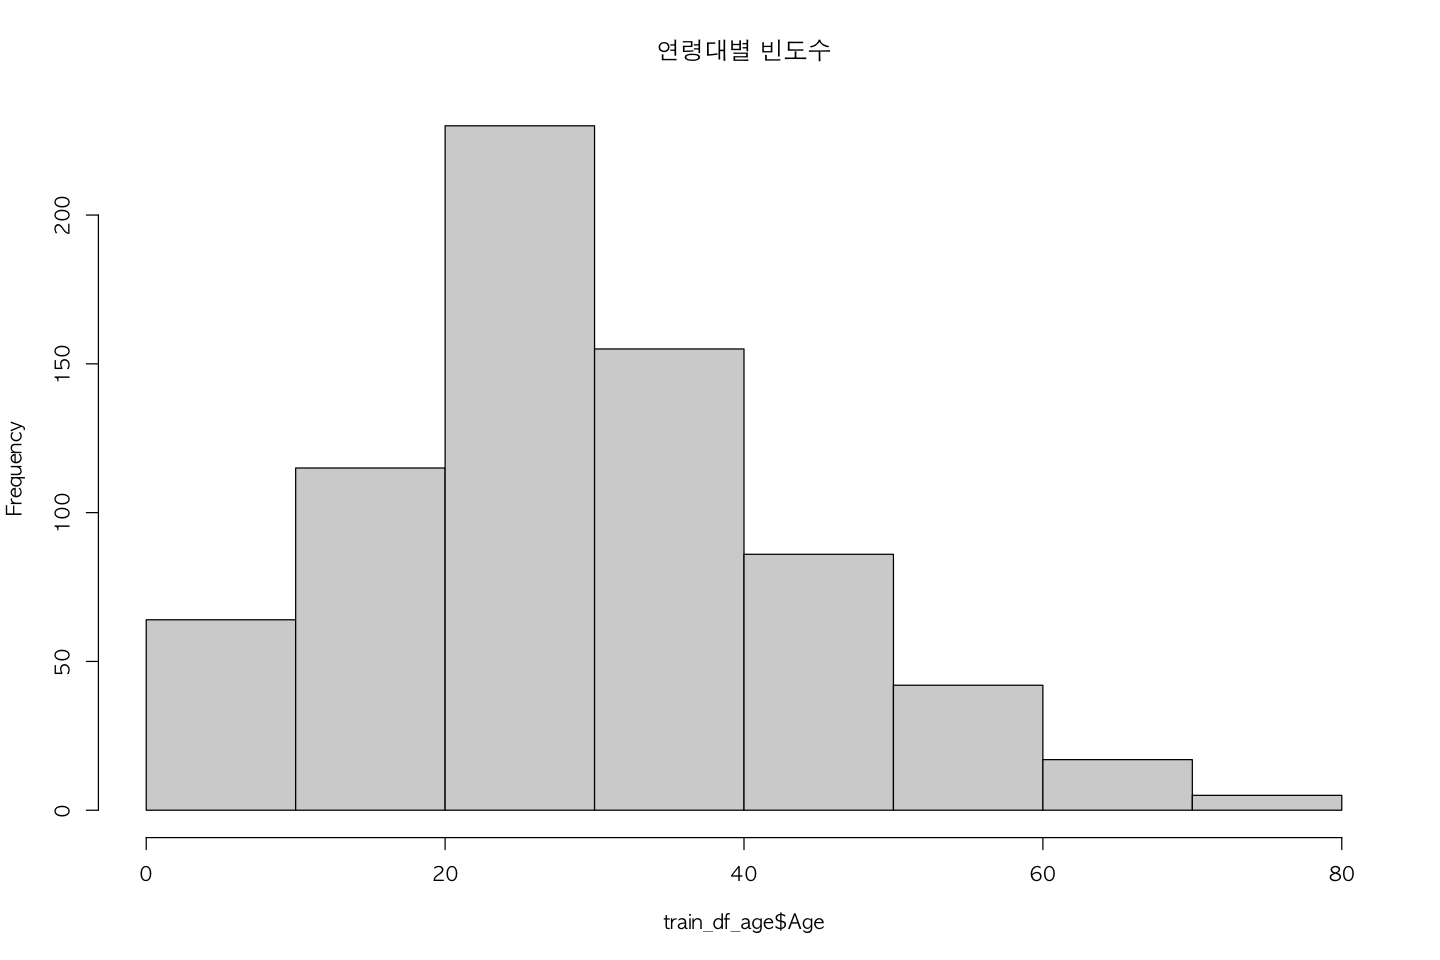

In [89]:
# Na 가 아닌 사람들의 연령대별 빈도수 
par(family = 'applegothic', bg ='white')
#freq(train_df_age$Age, main = "연령대별 빈도수")
hist(train_df_age$Age, main = "연령대별 빈도수", nclass =80/10)

In [101]:
# 연령대별 생존자, 사망자 분포
par(bg ="white")
table( train_df_age$Survived,train_df_age$Age)




   
    0.42 0.67 0.75 0.83 0.92  1  2  3  4  5  6  7  8  9 10 11 12 13 14 14.5 15
  0    0    0    0    0    0  2  7  1  3  0  1  2  2  6  2  3  0  0  3    1  1
  1    1    1    2    2    1  5  3  5  7  4  2  1  2  2  0  1  1  2  3    0  4
   
    16 17 18 19 20 20.5 21 22 23 23.5 24 24.5 25 26 27 28 28.5 29 30 30.5 31 32
  0 11  7 17 16 12    1 19 16 10    1 15    1 17 12  7 18    2 12 15    2  9  9
  1  6  6  9  9  3    0  5 11  5    0 15    0  6  6 11  7    0  8 10    0  8  9
   
    32.5 33 34 34.5 35 36 36.5 37 38 39 40 40.5 41 42 43 44 45 45.5 46 47 48 49
  0    1  9  9    1  7 11    1  5  6  9  7    2  4  7  4  6  7    2  3  8  3  2
  1    1  6  6    0 11 11    0  1  5  5  6    0  2  6  1  3  5    0  0  1  6  4
   
    50 51 52 53 54 55 55.5 56 57 58 59 60 61 62 63 64 65 66 70 70.5 71 74 80
  0  5  5  3  0  5  1    1  2  2  2  2  2  3  2  0  2  3  1  2    1  2  1  0
  1  5  2  3  1  3  1    0  2  0  3  0  2  0  2  2  0  0  0  0    0  0  0  1


  The decimal point is 1 digit(s) to the right of the |

  0 | 01111111111122233333444444455556678899
  1 | 12334445555666666777777888888888999999999
  2 | 00011111222222222223333344444444444444455555566666677777777777888888
  3 | 00000000001111111122222222233333334444445555555555566666666666788888
  4 | 0000001122222234445555578888889999
  5 | 00000112223444566888
  6 | 002233
  7 | 
  8 | 0



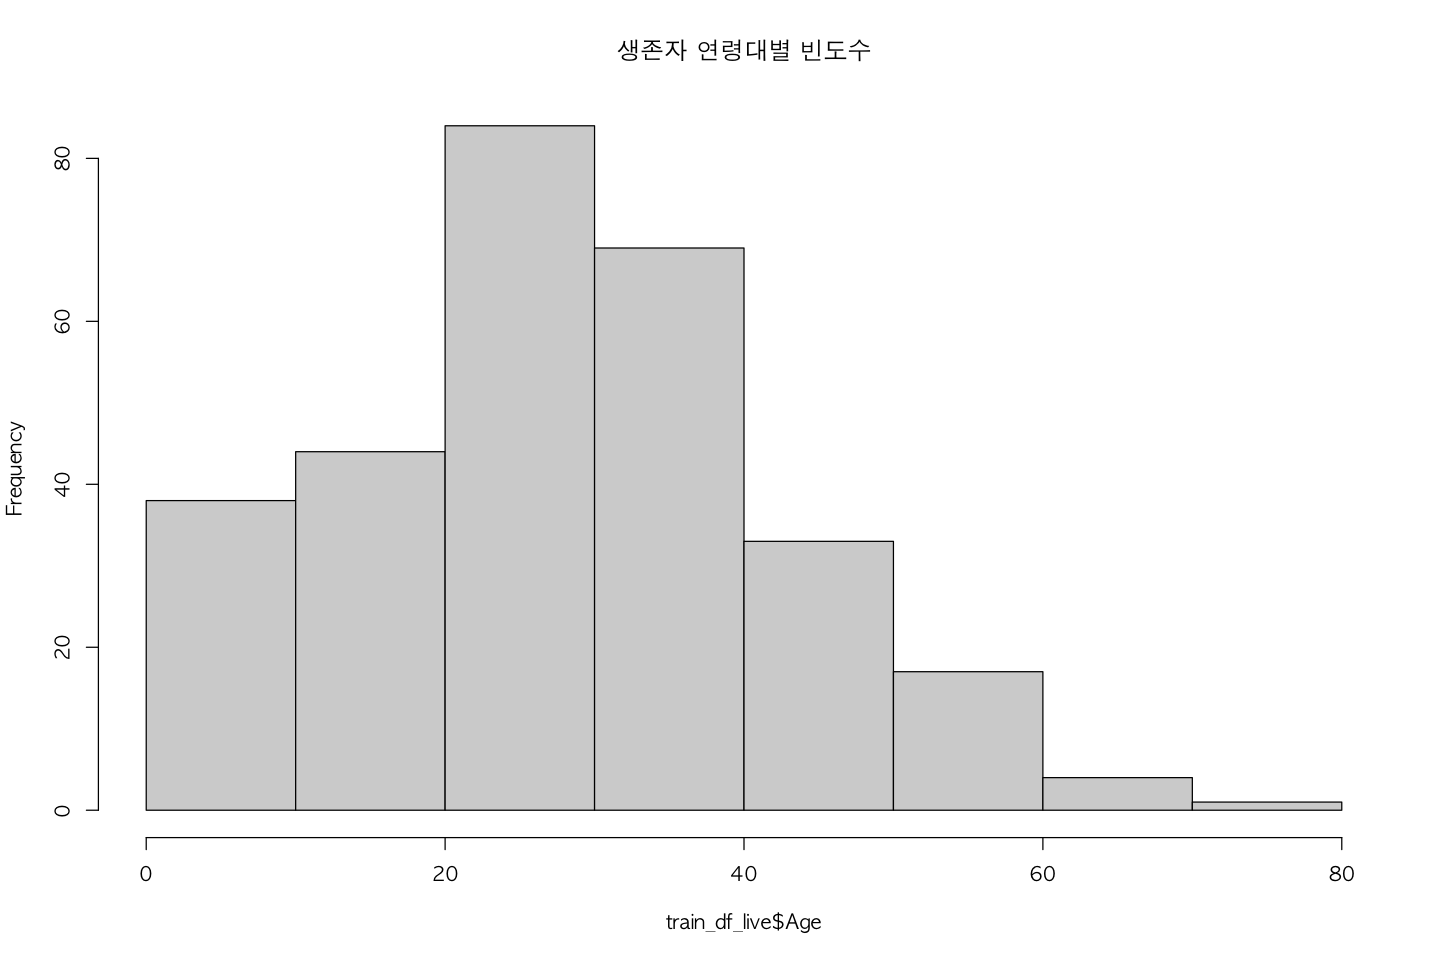

In [111]:
# 생존자들의 데이터 
train_df_live <- filter(train_df_age, Survived ==1)
par(bg = 'white', family ="applegothic")
hist(train_df_live$Age, main = "생존자 연령대별 빈도수", nclass =80/10)
stem(train_df_live$Age, scale =0.5)

## 20~40 이면 생존률이 높다. 40 이하 와40 이상을 나눈다. 

In [145]:

target_col <-c("Survived","SexCode","Pclass","Embarked_C","Embarked_S","Embarked_Q","Age")
#train_df_T[,target_col]

# Na 를  40 으로 전환
train_df_T$AgeCode<-train_df$Age
train_df_T$AgeCode[is.na(train_df_T$Age)]<-ifelse(train_df_T$Survived ==1, 20,50)
#train_df_T$AgeCode[!is.na(train_df_T$Age)]<-train_df_T$Age

target_col <-c("Survived","SexCode","Pclass","Embarked_C","Embarked_S","Embarked_Q","AgeCode")
train_df3<-train_df_T[,target_col]
train_df3$Survived<- as.factor(train_df3$Survived)

rfFunc(train_df3,1,100,5)



예측률 
0.8270677  0.8157895  0.8383459  0.8045113  0.8045113  
 Random Forest 평균 예측률 : 0.8180451

In [575]:
replaceNa_median<-median(train_df_live$Age);replaceNa_median
replaceNa_mean<-mean(train_df_live$Age);replaceNa_mean
replaceNa_q1<-quantile(train_df_live$Age, probs =0.25);
replaceNa_q2<-quantile(train_df_live$Age, probs =0.5);
replaceNa_q3<-quantile(train_df_live$Age, probs =0.75);
replaceNa_q08<-quantile(train_df_live$Age, probs =0.8);

# 이름 가지고 알수있는게 있다. , 어떤 이름이 제일 많은가?
train_df_T$AgeCode<-train_df$Age

# Na 를  40 으로 전환

simulationReplaceNa <- function (train_df,repNa){
    train_df_T$AgeCode<-train_df$Age
    train_df_T$AgeCode[is.na(train_df_T$Age)]<-repNa
    target_col <-c("Survived","SexCode","Pclass","Embarked_C","Embarked_S","Embarked_Q","AgeCode")
    train_df3<- train_df_T[,target_col]
    train_df3$Survived<- as.factor(train_df3$Survived)
    
    rfFunc(train_df3,1,100,10)
    return(train_df3)
}
simulationReplaceNa(train_df,replaceNa_median )
simulationReplaceNa(train_df,replaceNa_mean )
simulationReplaceNa(train_df,replaceNa_q1 )
simulationReplaceNa(train_df,replaceNa_q2 )
simulationReplaceNa(train_df,replaceNa_q3 )
simulationReplaceNa(train_df,replaceNa_q08 )




[1] 28

[1] 28.34369

예측률 
0.8007519  0.8233083  0.8157895  0.7932331  0.8233083  0.8045113  0.8195489  0.7781955  0.7969925  0.8157895  
 Random Forest 평균 예측률 : 0.8071429

Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode
<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>
0,0,3,FALSE,TRUE,FALSE,22
1,1,1,TRUE,FALSE,FALSE,38
1,1,3,FALSE,TRUE,FALSE,26
1,1,1,FALSE,TRUE,FALSE,35
0,0,3,FALSE,TRUE,FALSE,35
0,0,3,FALSE,FALSE,TRUE,28
0,0,1,FALSE,TRUE,FALSE,54
0,0,3,FALSE,TRUE,FALSE,2
1,1,3,FALSE,TRUE,FALSE,27


예측률 
0.8458647  0.8270677  0.8233083  0.8120301  0.8233083  0.7894737  0.8157895  0.8308271  0.7932331  0.8233083  
 Random Forest 평균 예측률 : 0.8184211

Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode
<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>
0,0,3,FALSE,TRUE,FALSE,22.00000
1,1,1,TRUE,FALSE,FALSE,38.00000
1,1,3,FALSE,TRUE,FALSE,26.00000
1,1,1,FALSE,TRUE,FALSE,35.00000
0,0,3,FALSE,TRUE,FALSE,35.00000
0,0,3,FALSE,FALSE,TRUE,28.34369
0,0,1,FALSE,TRUE,FALSE,54.00000
0,0,3,FALSE,TRUE,FALSE,2.00000
1,1,3,FALSE,TRUE,FALSE,27.00000


예측률 
0.8270677  0.8308271  0.7969925  0.7969925  0.7932331  0.8045113  0.8233083  0.8233083  0.8270677  0.8082707  
 Random Forest 평균 예측률 : 0.8131579

Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode
<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>
0,0,3,FALSE,TRUE,FALSE,22
1,1,1,TRUE,FALSE,FALSE,38
1,1,3,FALSE,TRUE,FALSE,26
1,1,1,FALSE,TRUE,FALSE,35
0,0,3,FALSE,TRUE,FALSE,35
0,0,3,FALSE,FALSE,TRUE,19
0,0,1,FALSE,TRUE,FALSE,54
0,0,3,FALSE,TRUE,FALSE,2
1,1,3,FALSE,TRUE,FALSE,27


예측률 
0.8082707  0.8270677  0.8195489  0.8345865  0.8082707  0.8308271  0.8571429  0.7932331  0.8157895  0.7969925  
 Random Forest 평균 예측률 : 0.8191729

Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode
<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>
0,0,3,FALSE,TRUE,FALSE,22
1,1,1,TRUE,FALSE,FALSE,38
1,1,3,FALSE,TRUE,FALSE,26
1,1,1,FALSE,TRUE,FALSE,35
0,0,3,FALSE,TRUE,FALSE,35
0,0,3,FALSE,FALSE,TRUE,28
0,0,1,FALSE,TRUE,FALSE,54
0,0,3,FALSE,TRUE,FALSE,2
1,1,3,FALSE,TRUE,FALSE,27


예측률 
0.8308271  0.8082707  0.7781955  0.7932331  0.8270677  0.8045113  0.8045113  0.8308271  0.8120301  0.8270677  
 Random Forest 평균 예측률 : 0.8116541

Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode
<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>
0,0,3,FALSE,TRUE,FALSE,22
1,1,1,TRUE,FALSE,FALSE,38
1,1,3,FALSE,TRUE,FALSE,26
1,1,1,FALSE,TRUE,FALSE,35
0,0,3,FALSE,TRUE,FALSE,35
0,0,3,FALSE,FALSE,TRUE,36
0,0,1,FALSE,TRUE,FALSE,54
0,0,3,FALSE,TRUE,FALSE,2
1,1,3,FALSE,TRUE,FALSE,27


예측률 
0.8421053  0.8308271  0.7857143  0.8308271  0.8120301  0.8270677  0.8082707  0.8007519  0.7932331  0.8233083  
 Random Forest 평균 예측률 : 0.8154135

Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode
<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>
0,0,3,FALSE,TRUE,FALSE,22
1,1,1,TRUE,FALSE,FALSE,38
1,1,3,FALSE,TRUE,FALSE,26
1,1,1,FALSE,TRUE,FALSE,35
0,0,3,FALSE,TRUE,FALSE,35
0,0,3,FALSE,FALSE,TRUE,40
0,0,1,FALSE,TRUE,FALSE,54
0,0,3,FALSE,TRUE,FALSE,2
1,1,3,FALSE,TRUE,FALSE,27


In [581]:
# 3사분위 값으로 나이 대체
replaceNa_q3<-quantile(train_df_live$Age, probs =0.75);
replaceNa_q3
# train_df_age<- filter(train_df, !is.na(train_df$Age))
train_df2_T<-simulationReplaceNa(train_df,replaceNa_q3 )
cat("!!!!!!!")

head(train_df2_T)
for( i in 1:length(train_df2_T[,1])){
    if(train_df2_T$Age[i] >70){
        train_df2_T$AgeCode[i] <-1
    }
    else if(train_df2_T$Age[i] >60){
        train_df2_T$AgeCode[i] <-1.5
    }
    else if(train_df2_T$Age[i] >50){
        train_df2_T$AgeCode[i] <-2
    }
    else if(train_df2_T$Age[i] >40){
        train_df2_T$AgeCode[i] <-4
    }
    else if(train_df2_T$Age[i] >30){
        train_df2_T$AgeCode[i] <-5
    }
    else if(train_df2_T$Age[i] >10){
        train_df2_T$AgeCode[i] <-5
    }
    else if(train_df2_T$Age[i] >3){
        train_df2_T$AgeCode[i] <-7
    }
}



75% 
 36

예측률 
0.8345865  0.8345865  0.8082707  0.8496241  0.7894737  0.7969925  0.8345865  0.8082707  0.8383459  0.8157895  
 Random Forest 평균 예측률 : 0.8210526!!!!!!!

,Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode
,<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>
1,0,0,3,FALSE,TRUE,FALSE,22
2,1,1,1,TRUE,FALSE,FALSE,38
3,1,1,3,FALSE,TRUE,FALSE,26
4,1,1,1,FALSE,TRUE,FALSE,35
5,0,0,3,FALSE,TRUE,FALSE,35
6,0,0,3,FALSE,FALSE,TRUE,36


In [586]:
# 3사분위 값으로 나이 대체
replaceNa_q3<-quantile(train_df_live$Age, probs =0.80);
replaceNa_q3
# train_df_age<- filter(train_df, !is.na(train_df$Age))
train_df2_T<-simulationReplaceNa(train_df,replaceNa_q3 )
cat("!!!!!!!")

head(train_df2_T)


for( i in 1:length(train_df2_T[,1])){
    if(train_df2_T$Age[i] >70){
        train_df2_T$AgeCode[i] <-1
    }
    else if(train_df2_T$Age[i] >60){
        train_df2_T$AgeCode[i] <-1.5
    }
    else if(train_df2_T$Age[i] >50){
        train_df2_T$AgeCode[i] <-2
    }
    else if(train_df2_T$Age[i] >40){
        train_df2_T$AgeCode[i] <-4
    }
    else if(train_df2_T$Age[i] >30){
        train_df2_T$AgeCode[i] <-5
    }
    else if(train_df2_T$Age[i] >10){
        train_df2_T$AgeCode[i] <-5
    }
    else if(train_df2_T$Age[i] >3){
        train_df2_T$AgeCode[i] <-7
    }
}
#train_df2_T[-Age]


#train_df2_T
target_col <-c("Survived","SexCode","Pclass","Embarked_C","Embarked_S","Embarked_Q","AgeCode")
train_df2_T<- train_df2_T[,target_col]
train_df2_T$Survived<- as.factor(train_df2_T$Survived)

#train_df2_T
rfFunc(train_df2_T,1,100,10)

train_df2_T

80% 
 40

예측률 
0.7857143  0.8045113  0.8383459  0.8082707  0.8195489  0.7744361  0.8195489  0.8233083  0.8533835  0.8646617  
 Random Forest 평균 예측률 : 0.8191729!!!!!!!

,Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode
,<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>
1,0,0,3,FALSE,TRUE,FALSE,22
2,1,1,1,TRUE,FALSE,FALSE,38
3,1,1,3,FALSE,TRUE,FALSE,26
4,1,1,1,FALSE,TRUE,FALSE,35
5,0,0,3,FALSE,TRUE,FALSE,35
6,0,0,3,FALSE,FALSE,TRUE,40


예측률 
0.8082707  0.8270677  0.8458647  0.7631579  0.8007519  0.8157895  0.7969925  0.7781955  0.8082707  0.7819549  
 Random Forest 평균 예측률 : 0.8026316

Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode
<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>
0,0,3,FALSE,TRUE,FALSE,5
1,1,1,TRUE,FALSE,FALSE,5
1,1,3,FALSE,TRUE,FALSE,5
1,1,1,FALSE,TRUE,FALSE,5
0,0,3,FALSE,TRUE,FALSE,5
0,0,3,FALSE,FALSE,TRUE,5
0,0,1,FALSE,TRUE,FALSE,2
0,0,3,FALSE,TRUE,FALSE,2
1,1,3,FALSE,TRUE,FALSE,5


예측률 
0.8533835  0.8458647  0.8345865  0.8308271  0.8045113  0.7894737  0.8421053  0.8533835  0.8195489  0.8157895  0.8383459  0.8270677  0.7932331  0.8345865  0.8796992  0.8421053  0.8195489  0.8270677  0.8195489  0.8157895  0.8233083  0.8571429  0.8270677  0.8458647  0.8045113  0.8458647  0.8345865  0.8383459  0.8195489  0.8684211  0.8496241  0.8571429  0.8496241  0.8345865  0.8270677  0.8345865  0.8308271  0.8082707  0.8195489  0.8120301  0.8571429  0.8007519  0.8308271  0.8496241  0.8458647  0.8721805  0.8007519  0.8157895  0.8421053  0.8759398  
 Random Forest 평균 예측률 : 0.8333083

,Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,AgeCode,Fare3,SibPar,SibPar2,FC,Cl_mul_Age,nameTypeMr,nameTypeMiss,nameTypeMaster,nameTypeMrs,nameTypeEtc
,<fct>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,0,0,3,FALSE,TRUE,FALSE,5,3.810781e+02,2,4,21.7500,15,TRUE,FALSE,FALSE,FALSE,FALSE
2,1,1,1,TRUE,FALSE,FALSE,5,3.622125e+05,2,4,71.2833,5,FALSE,FALSE,FALSE,TRUE,FALSE
3,1,1,3,FALSE,TRUE,FALSE,5,4.977346e+02,1,1,23.7750,15,FALSE,TRUE,FALSE,FALSE,FALSE
4,1,1,1,FALSE,TRUE,FALSE,5,1.497213e+05,2,4,53.1000,5,FALSE,FALSE,FALSE,TRUE,FALSE
5,0,0,3,FALSE,TRUE,FALSE,5,5.216601e+02,1,1,24.1500,15,TRUE,FALSE,FALSE,FALSE,FALSE
6,0,0,3,FALSE,FALSE,TRUE,5,6.051308e+02,1,1,25.3749,15,TRUE,FALSE,FALSE,FALSE,FALSE
7,0,0,1,FALSE,TRUE,FALSE,2,1.394955e+05,1,1,51.8625,2,TRUE,FALSE,FALSE,FALSE,FALSE
8,0,0,3,FALSE,TRUE,FALSE,2,9.360580e+03,5,25,63.2250,6,FALSE,FALSE,TRUE,FALSE,FALSE
9,1,1,3,FALSE,TRUE,FALSE,5,1.379977e+03,3,9,33.3999,15,FALSE,FALSE,FALSE,TRUE,FALSE


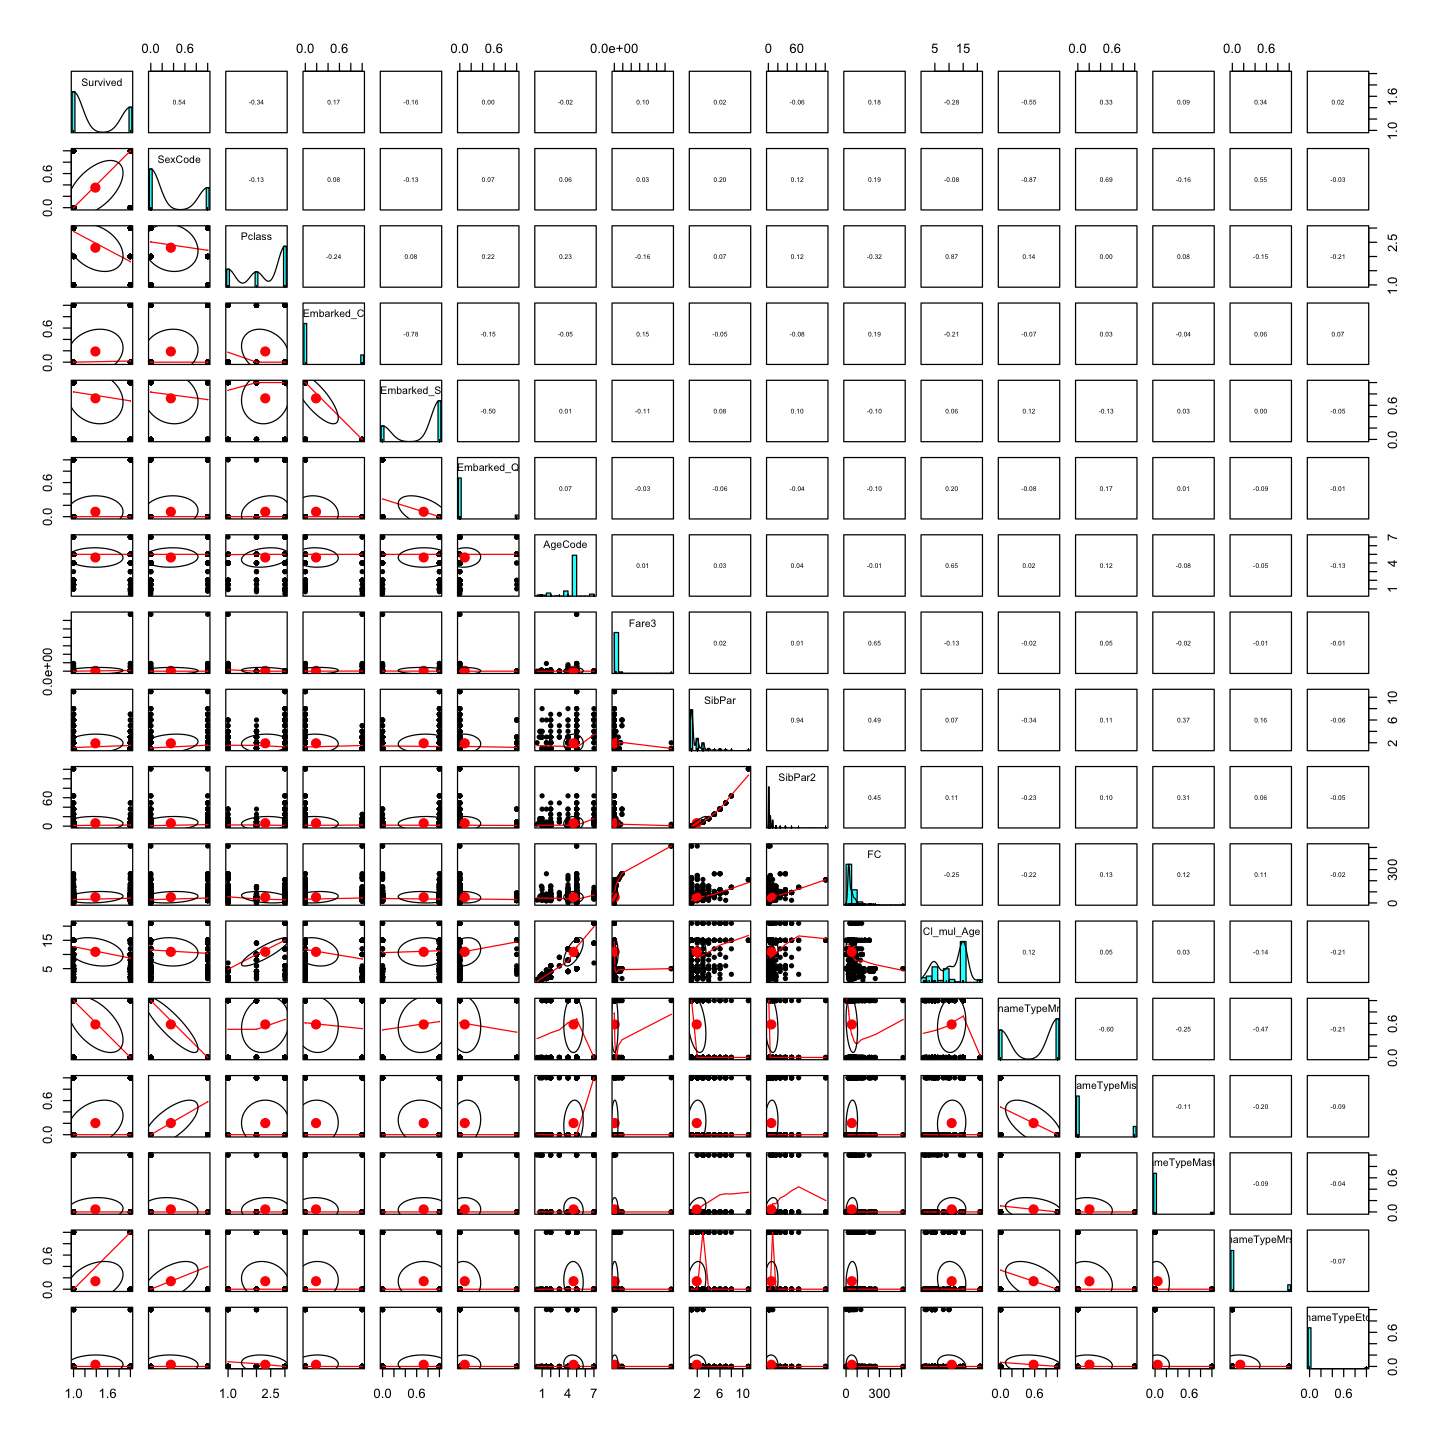

In [678]:
# column생성 
options(repr.plot.width =12, repr.plot.height =12)

train_df2_T1<-train_df2_T



## Mr, Miss, Mrs, Master, etc 로 나누어 칼럼 생성 
nameType<- c()
for( i in 1:length(train_df$Name)){
    #cat(train_df$Name[i])
    #cat(str_locate(train_df$Name[i],","), "\n")
    a<-str_locate(train_df$Name[i],",")
    b<-substring(train_df$Name[i], first=a+1, last= a+10)[1]
    #cat(b," ")
    #cat(str_locate(b,". ")[1],"\n")
    c<-substring(b, first=1, last= str_locate(b,". ")[1]-1)[1] 
    #cat(str_detect(c,"Mr"))
    if(is.na(c)){
        #cat("!!!!",i)
        nameType<- append(nameType,"etc")
    }else{
        if( str_detect(c,"Mr") |str_detect(c,"Master")|str_detect(c,"Miss")){
            nameType<- append(nameType,c)
        }else{
            nameType<- append(nameType,"etc")
    }
    }
}



#train_df2_T1<- subset(train_df2_T1, select =-AgeCode)
for( i in 1:nrow(train_df2_T1)){


    #important factors
        
    # Fare
    train_df2_T1$Fare3[i] <- train_df$Fare[i]^3
    
    # Family Size
    train_df2_T1$SibPar[i] <- train_df$SibSp[i]+train_df$Parch[i]+1
    train_df2_T1$SibPar2[i] <- (train_df$SibSp[i]+train_df$Parch[i]+1)^2
    
    

    #Pclass * Fare
    train_df2_T1$FC[i] <- train_df2_T1$Pclass[i]*train_df$Fare[i]


    # Name type
    train_df2_T1$nameType[i] <-nameType[i]

    # class * Age = -0.28
    train_df2_T1$Cl_mul_Age[i] <- (train_df2_T1$Pclass[i]*train_df2_T1$AgeCode[i])

    #total mul
    #train_df2_T1$X[i]<-((train_df$Fare[i]^2)*train_df2_T1$SibPar2[i])/ ifelse((train_df2_T1$FCA[i])!=0, train_df2_T1$FCA[i],1 )*train_df2_T1$AgeCode
    #train_df2_T1$X[i]<-(train_df$Fare[i])*ifelse(train_df2_T1$SexCode[i]==1,10,0.1)/(train_df$Pclass[i]^2)/train_df2_T1$Cl_mul_Age[i]

    #train_df2_T1$S <-ifelse(train_df_T$SexCode[i]==1,100,0.1)

    #train_df2_T1$S[i]<-round(train_df2_T1$X[i]*10)

    #train_df2_T1$Cl_mul_Age2[i] <- (train_df2_T1$Pclass[i]*train_df2_T1$Age[i]- trunc(train_df$Fare[i]))

    # Fare = 0.26
    #train_df2_T1$Fare[i] <- trunc(train_df$Fare[i])#/mean(train_df$Fare)
    #train_df2_T1$Fare2[i] <- trunc(train_df$Fare[i])^2
    #train_df2_T1$Fare3[i] <- trunc(train_df$Fare[i])^3


    #SibSp*Parch =-0.08
    #train_df2_T1$SibPar[i] <- train_df$SibSp[i]+train_df$Parch[i]+1

    # Fare * Age = 0.25
    #train_df2_T1$Fare_mul_Age[i] <- train_df$Fare[i]*train_df2_T$Age[i]
    #train_df2_T1$Fare_mul_Age2[i] <- (train_df$Fare[i]*train_df2_T$Age[i])^2
    
    # Fare * class  =
    #train_df2_T1$FCA[i] <- train_df2_T1$Pclass[i]*train_df$Fare[i]
    #train_df2_T1$FCA_2[i]<-train_df2_T1$FCA[i] *train_df2_T1$Cl_mul_Age[i]
    
    #train_df2_T1$nameType[i] <-nameType[i]
    
    #train_df2_T1$FCA_3[i]<-train_df2_T1$Fare_mul_Age[i]*train_df2_T1$FCA_2[i]
    #train_df2_T1$FCA_4[i]<-train_df2_T1$SibPar[i]*train_df2_T1$FCA_3[i]
    #train_df2_T1$FCA_5[i]<-train_df2_T1$SibPar[i]*train_df2_T1$FCA_3[i]


}
#train_df2_T1$nameType
## one hot encoding 
train_df2_T1$nameTypeMr <-train_df2_T1$nameType ==" Mr"
train_df2_T1$nameTypeMiss <- train_df2_T1$nameType ==" Miss"
train_df2_T1$nameTypeMaster <- train_df2_T1$nameType ==" Master"
train_df2_T1$nameTypeMrs <- train_df2_T1$nameType ==" Mrs"
train_df2_T1$nameTypeEtc <- train_df2_T1$nameType =="etc"
train_df2_T1<-subset(train_df2_T1, select =-nameType)
#train_df2_T1


#rain_df2_T<-subset(train_df2_T, select =-Embarked_Q)
svmFunc(train_df2_T1,1,130,50)

train_df2_T1
par(bg ='white')
pairs.panels(train_df2_T1)

In [657]:
# RandomForrest Prediction
library(e1071)
# RandomForest 생사여부 예측률과 오분류표 구하기 
# RandomForrest Prediction
svmFunc <- function(data,target_col,rf_n,iter_n){
    Sys.setlocale(category = "LC_ALL", locale = "ko_KR.UTF-8") # 한글 설정
    target <- data[,target_col] # target 칼럼
    acc_rf <-c()
    acc_nn <-c()
    cat("예측률 \n")

    for(i in 1:iter_n){
        samp <- createDataPartition(data[,target_col], p =0.7, list =F)
        # 학습용, 검증용 분류
        data.tr     <- data[samp,]
        data.test   <- data[-samp,]
        # 문제 및 정답 만들기 
        x <- subset(data.test, select = -target_col)
        y <- data.test[,target_col]
        
        # 모델 생성
        target_name     <-colnames(data)[target_col] 
        Training_target <-data.frame(Survived=data.tr[,target_col])

        #model.nnet <- nnet(Training_target$V1 ~ ., data =data.tr, size = 3, trace =F) 

        #rf <- randomForest(Training_target$Survived ~ ., data =data.tr, ntree =rf_n)
        rf <- svm(Training_target$Survived~ .,data =data.tr)
        # 예측
        pred_rf <-predict(rf,x )
        #pred_nn <-predict(model.nnet,x )
        acc_rf<-append(acc_rf,mean(pred_rf == y))
        #acc_nn<-append(acc_nn,mean(pred_nn == y))
        cat(mean(pred_rf ==y)," ")
    }
    cat("\n\033[36m Random Forest 평균 예측률 : ",mean(acc_rf) ,"\033[0m",sep = "")
    #cat("\n\033[36m Neural Network 평균 예측률 : ",mean(acc_nn) ,"\033[0m",sep = "")
    #return(mean(acc))
}




!!!! 823

,Frequency,Percent
Master,40,4.489338
Miss,182,20.426487
Mr,517,58.024691
Mrs,125,14.029181
etc,27,3.030303
Total,891,100.000000


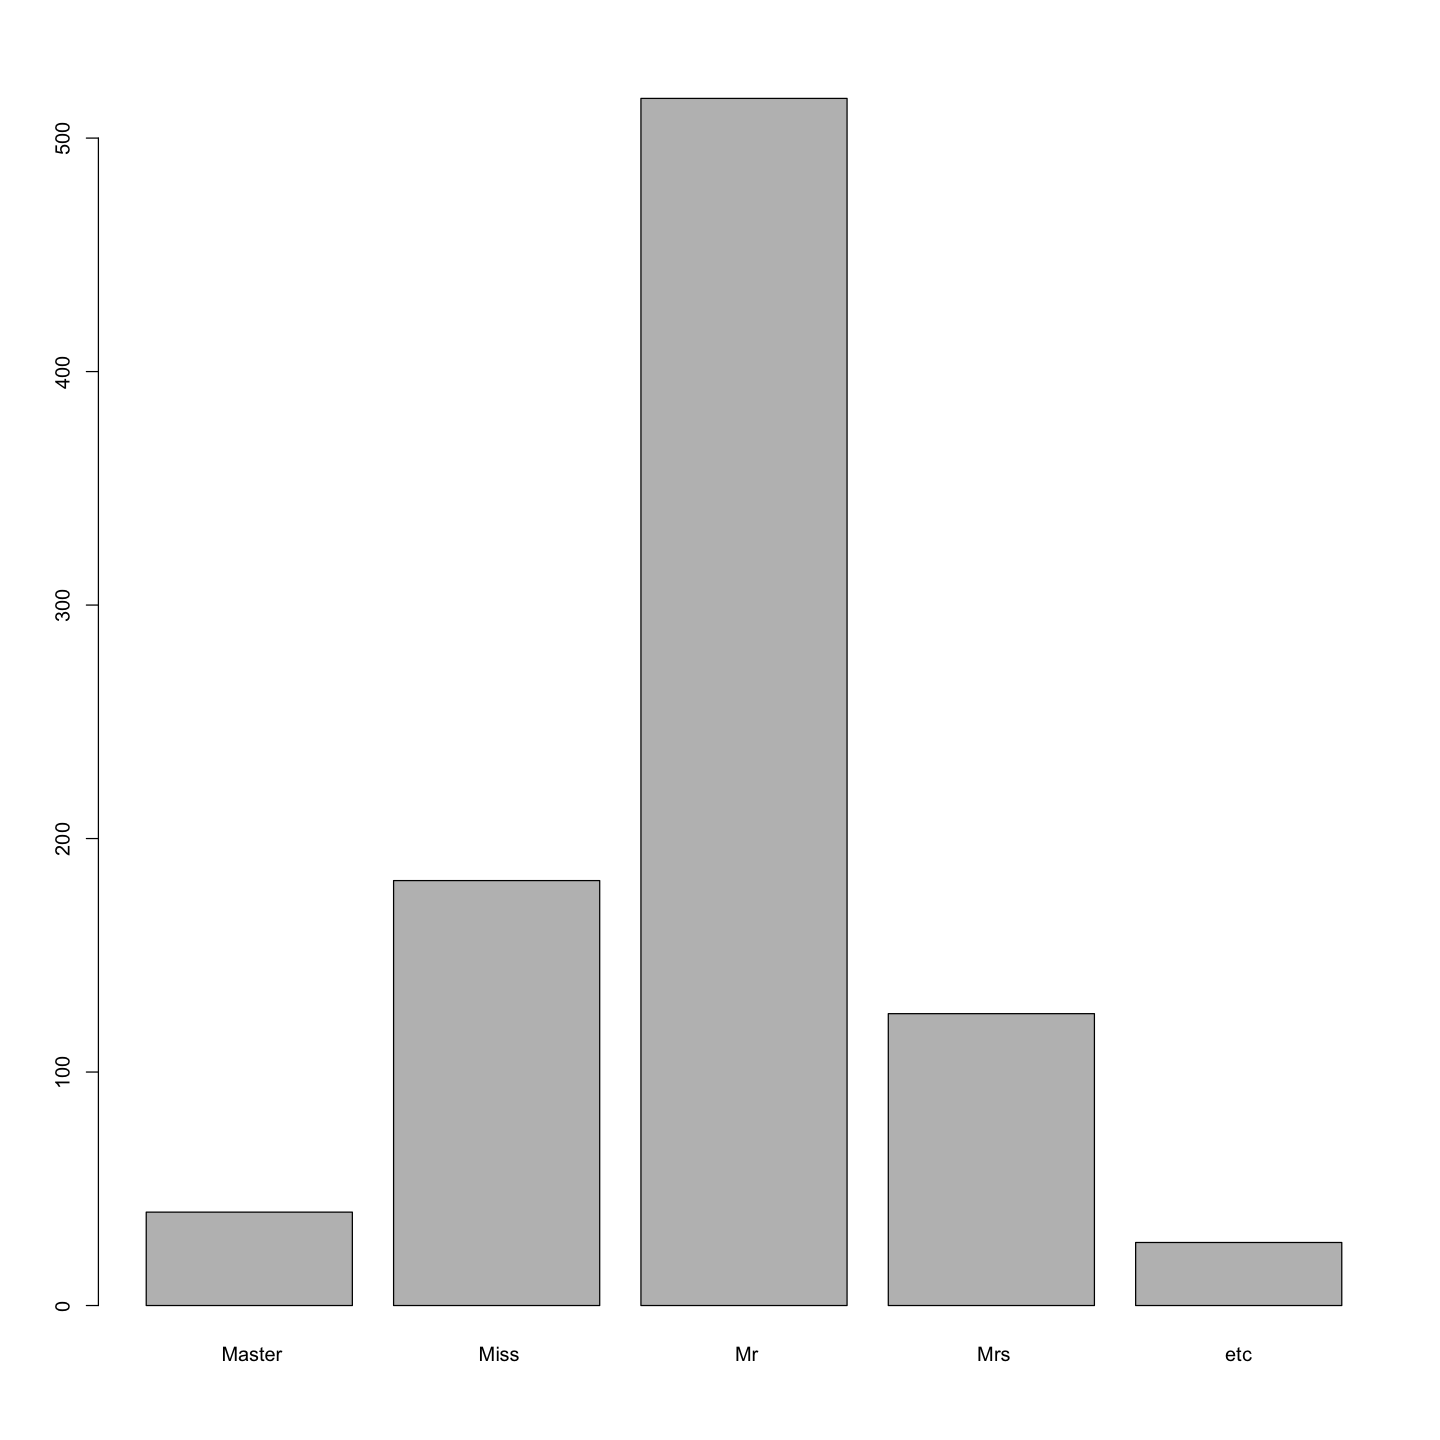

In [517]:
nameType<- c()
for( i in 1:length(train_df$Name)){
    #cat(train_df$Name[i])
    #cat(str_locate(train_df$Name[i],","), "\n")
    a<-str_locate(train_df$Name[i],",")
    b<-substring(train_df$Name[i], first=a+1, last= a+10)[1]
    #cat(b," ")
    #cat(str_locate(b,". ")[1],"\n")
    c<-substring(b, first=1, last= str_locate(b,". ")[1]-1)[1] 
    #cat(str_detect(c,"Mr"))
    if(is.na(c)){
        cat("!!!!",i)
          nameType<- append(nameType,"etc")
    }else{
        if( str_detect(c,"Mr") |str_detect(c,"Master")|str_detect(c,"Miss")){
            nameType<- append(nameType,c)
        }else{
            nameType<- append(nameType,"etc")
    }
    }
}
freq(nameType)

In [499]:
sum(is.na(train_df$Name))

[1] 0